# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento da base**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extração de amostra dos dataframes
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Análise de cardinalidade
    - 3.3. Análise de variáveis não numéricas
    - 3.4. Selecionando variáveis não aplicáveis à modelagem
    - 3.5. Segmentação das bases **train** e **test**
    - 3.6. Transformação das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos
    - 4.2. Rankeamento dos modelo por score
    - 4.3. Tunagem dos hiperparâmetros do modelo com Optuna
        - 4.3.1. Ajustes de parâmetros globais para os modelos
        - 4.3.2. Tunagem do modelo **Bayesian Ridge**
        - 4.3.3. Tunagem do modelo **Lasso**
        - 4.3.4. Tunagem do modelo **ElasticNet**
        - 4.3.5. Tunagem do modelo **Ridge**
    - 4.4. Salvando os modelos (.pkl)
    - 4.5. Análise gráfica de resíduos x previsões
5. **Conclusões**

<br>

---

<br>

## 1. Importação de bibliotecas

In [46]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna
import joblib
import os
import random

from sklearn.metrics import (make_scorer, mean_squared_error, mean_absolute_error, r2_score) 
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge)
from optuna.samplers import TPESampler

In [47]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar opção para exibir todas as linhas do Dataframe
pd.set_option('display.max_rows', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos do Seaborn
sns.set_style('whitegrid')

## 2. Carregamento da base

In [48]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 4216


In [49]:
# Criando um dataframe a partir do arquivo *.csv

df = pd.read_csv('dados/Car_Purchasing_Data_Atualizado.csv', sep=';')
df.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount,debt_to_annual_salary,...,age_adjusted_income,wealth_growth_rate,financial_maturity_index,email_tld,age_range,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877,0.184827,...,9692.116370,0.090581,2.717416,edu,35 to 44,0,0,0,0,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566,0.143637,...,10408.495986,0.194316,5.829491,uk,35 to 44,0,0,1,1,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921,0.207447,...,8204.202132,0.275994,8.279818,uk,35 to 44,0,0,1,1,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313,0.181758,...,10421.796563,0.119171,3.575129,com,55 to 64,1,0,1,0,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248,0.089717,...,7911.319356,0.164575,4.937235,net,55 to 64,0,0,1,0,Moderate


## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [50]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata

In [51]:
generate_metadata(df)

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,Customer Name,object,0,0.0,498
1,Customer e-mail,object,0,0.0,500
2,Country,object,0,0.0,1
3,Gender,int64,0,0.0,2
4,Age,int64,0,0.0,43
5,Annual Salary,float64,0,0.0,500
6,Credit Card Debt,float64,0,0.0,500
7,Net Worth,float64,0,0.0,500
8,Car Purchase Amount,float64,0,0.0,500
9,debt_to_annual_salary,float64,0,0.0,500


### 3.2. Análise de cardinalidade

In [52]:
# Listando todas as variáveis com cardinalidade inferior a 2

cols_low_cardinality = [col for col in df.columns if df[col].nunique(dropna=False) < 2]
print(cols_low_cardinality)


['Country']


### 3.3. Análise de variáveis não numéricas

In [53]:
# Listando todas as variáveis object e category

cols_text = df.select_dtypes(include=[object, 'category']).columns.tolist()
print(cols_text)

['Customer Name', 'Customer e-mail', 'Country', 'email_tld', 'age_range', 'financial_status_category']


In [54]:
df[cols_text].head()

,Customer Name,Customer e-mail,Country,email_tld,age_range,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,edu,35 to 44,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,uk,35 to 44,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,uk,35 to 44,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,com,55 to 64,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,net,55 to 64,Moderate


In [55]:
# Detectar variáveis binárias (0 ou 1)
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()) <= {0, 1}
]
print(binary_cols)

# Transformando variáveis binárias (0 ou 1) em categóricas
df[binary_cols] = df[binary_cols].astype('category')

['Gender', 'high_income_flag', 'high_debt_flag', 'high_net_worth_flag', 'high_ppi_flag']


In [56]:
df[binary_cols].head()

,Gender,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag
0,0,0,0,0,0
1,0,0,0,1,1
2,1,0,0,1,1
3,1,1,0,1,0
4,1,0,0,1,0


### 3.4. Selecionando variáveis não aplicáveis à modelagem

In [57]:
# Separando as variáveis não aplicáveis à modelagem

vars_to_remove = ['Customer Name', 'Customer e-mail', 'Country']
if 'Age' in df.columns and 'age_range' in df.columns:
    vars_to_remove.append('Age')


### 3.5. Segmentação das bases **train** e **test**

In [58]:
# Separando as variáveis preditivas e a variável preditora (alvo)

target = 'Car Purchase Amount'
features = [col for col in df.columns if col not in [target] + vars_to_remove]


In [59]:
# Separação das features e o target
X = df[features]
y = df[target]

# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 3.6. Transformação das features das bases **train** e **test**

In [60]:
# Separando as variáveis numéricas e categóricas

numerical_features = X.select_dtypes(exclude=[object, 'category']).columns
categorical_features = X.select_dtypes(include=[object, 'category']).columns

In [61]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('variance', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [62]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [63]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (400, 26), y_train: (400,)
Shape: X_test:  (100, 26),  y_test: (100,)


In [64]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [65]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_processed.shape}')
print(f'Shape de X_test após transformação:  {X_test_processed.shape}')

Shape de X_train após transformação: (400, 43)
Shape de X_test após transformação:  (100, 43)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos

In [66]:
# Definindo os modelos a serem testados

models =  { 
    'LinearRegression (BASELINE)': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
}


In [67]:
def models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5, cv_repeats=10):
    '''
    Avalia modelos de aprendizado de máquina, calculando métricas de desempenho 
    no conjunto de treino e teste.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada.
    :param cv_repeats: int, default=10
        Número de repetições para a validação cruzada repetida (RepeatedKFold).

    :return: list
        Lista contendo os resultados de avaliação de cada modelo, métricas para treino 
        e teste, além do tempo de execução.
    '''
    results = []
    
    # Inicializa o esquema de validação cruzada com repetições
    cv = RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }
    
    # Loop pelos modelos a serem avaliados
    for model_name, model in models.items():
        # Cria um pipeline que combina o pré-processamento e o modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Registra o tempo de início
        start_time = time.time()
        
        # Executa validação cruzada no pipeline
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
        )
        
        # Calcula médias das métricas (convertendo para valores positivos)
        mean_cv_mae = -np.mean(cv_results['test_MAE'])
        mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
        mean_cv_r2 = np.mean(cv_results['test_R2'])
        
        # Ajusta o modelo final em todos os dados de treino
        pipeline.fit(X_train, y_train)
        
        # Gera previsões no conjunto de teste
        preds = pipeline.predict(X_test)
        
        # Métricas no teste
        test_rmse = np.sqrt(mean_squared_error(y_test, preds))
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)
        
        # Calcula tempo total de execução
        elapsed = time.time() - start_time
        
        # Guarda resultados
        results.append({
            'Model': model_name,
            'CV_RMSE': mean_cv_rmse,
            'Test_RMSE': test_rmse,
            'CV_MAE': mean_cv_mae,
            'Test_MAE': test_mae,
            'CV_R2': mean_cv_r2,            
            'Test_R2': test_r2,
            'Time (s)': round(elapsed, 4)
        })
        
    return results

### 4.2. Rankeamento dos modelo por score

In [68]:
def zscore_norm(series):
    '''
    Normalização Z-score: (x - média) / desvio padrão

    :param series: pd.Series
        Série numérica a ser normalizada.

    :return: pd.Series or float
        Série normalizada usando Z-score.
        Retorna 0.0 caso desvio padrão seja zero (todos iguais).
    '''
    if series.std() == 0:
        return pd.Series(0.0, index=series.index)
    
    return (series - series.mean()) / series.std()


def add_final_score(df, w_mae=0.80, w_time=0.20):
    '''
    Adiciona colunas normalizadas e calcula um ranking Final_Score
    usando Z-score utilizando pesos proporcionais.

    :param df: pd.DataFrame
        DataFrame contendo as métricas dos modelos.
    :param w_mae: float, default=0.80
        Peso atribuído à métrica MAE na composição do score final.
    :param w_time: float, default=0.20
        Peso atribuído ao tempo de execução na composição do score final.   

    :return: pd.DataFrame
        DataFrame com colunas normalizadas e ranking Final_Score.
    '''

    # Normalização robusta
    df['MAE_norm'] = zscore_norm(df['Test_MAE'])
    df['Time_norm'] = zscore_norm(df['Time (s)'])

    # Score final (menor = melhor)
    df['Final_Score'] = (
        w_mae * df['MAE_norm'] +
        w_time * df['Time_norm']
    )

    # Ordenação para ranking
    df.sort_values('Final_Score', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [69]:
# Avaliando os modelos
results = models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
df_ranked = pd.DataFrame(results)

# Adicionando o score final ao DataFrame de resultados
df_ranked_default = add_final_score(df_ranked)

print('\nResultado dos modelos SEM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_default[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado dos modelos SEM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,BayesianRidge,638.908211,588.939077,0.2975,-0.545506,-0.454592,-0.527323
1,Lasso,771.712695,783.743438,0.3689,-0.372820,-0.386067,-0.375469
2,Ridge,855.427365,879.050373,0.2681,-0.288334,-0.482809,-0.327229
3,LinearRegression (BASELINE),645.447939,561.578690,2.6338,-0.569760,1.787658,-0.098276
4,ElasticNet,3129.161097,3208.260115,0.2875,1.776419,-0.464190,1.328298


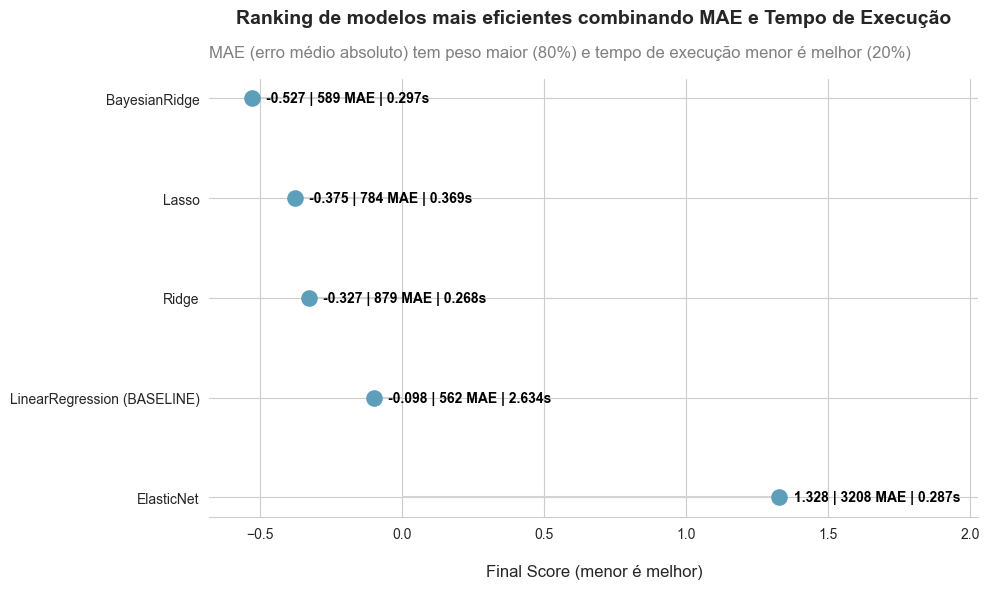

In [70]:
# Ordenar os modelos pelo Final_Score para o gráfico
df_plot = df_ranked_default.sort_values(by='Final_Score', ascending=False)

# Figura e eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Linha horizontal
ax.hlines(y=df_plot['Model'], xmin=df_plot['Final_Score'], xmax=0,
    color='lightgray', linewidth=1.5)

# Pontos no valor real
ax.scatter(df_plot['Final_Score'], df_plot['Model'], 
           color='#5d9eba', s=120, zorder=3)

# Adicionar texto com MAE e tempo
for score, mae, time_s, model in zip(
    df_plot['Final_Score'], df_plot['Test_MAE'], df_plot['Time (s)'], df_plot['Model']):
    ax.text(score + 0.05, model, f'{score:.3f} | {mae:.0f} MAE | {time_s:.3f}s',
        fontweight='bold', va='center', fontsize=10, color='#000000')

# Título e labels
ax.set_title('Ranking de modelos mais eficientes combinando MAE e Tempo de Execução',
             fontsize=14, fontweight='bold', pad=40)
ax.set_xlabel('\nFinal Score (menor é melhor)', fontsize=12)
ax.set_ylabel('')

# Subtítulo explicativo
ax.text(0, 1.05, 
        'MAE (erro médio absoluto) tem peso maior (80%) e tempo de execução menor é melhor (20%)',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)

# Ajuste de eixo para não cortar textos
ax.set_xlim(df_plot['Final_Score'].min() - 0.15,
            df_plot['Final_Score'].max() + 0.7)

# limpar borda superior e direita
sns.despine(left=True, bottom=False) 

# Ajuste final do layout para evitar sobreposição
plt.tight_layout()

# Exibição do gráfico
plt.show()


### 4.3. Tunagem dos hiperparâmetros do modelo com Optuna

#### 4.3.1. Ajustes de parâmetros globais para os modelos

In [71]:
def set_global_seed(seed=42):
    '''
    Define uma semente global para garantir reprodutibilidade em operações
    envolvendo geração de números aleatórios.

    :param seed: int, default=42
        Valor da semente que será aplicada globalmente.

    :return: None
        Não retorna valores. Apenas configura o ambiente.
    '''

    # Seed para NumPy
    np.random.seed(seed)

    # Seed para random (biblioteca padrão do Python)
    random.seed(seed)

    # Seed para hashing interno do Python
    os.environ['PYTHONHASHSEED'] = str(seed)


In [72]:
# Validação cruzada estável (50 folds = 5x10)
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Usamos MAE negativo porque Optuna minimiza a função de objetivo
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

#### 4.3.2. Tunagem do modelo **Bayesian Ridge**

In [73]:
def objective_bayesianridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo BayesianRidge usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = BayesianRidge(
        max_iter=trial.suggest_int('max_iter', 300, 1500),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        alpha_1=trial.suggest_float('alpha_1', 1e-8, 1e-5, log=True),
        alpha_2=trial.suggest_float('alpha_2', 1e-8, 1e-5, log=True),
        lambda_1=trial.suggest_float('lambda_1', 1e-8, 1e-5, log=True),
        lambda_2=trial.suggest_float('lambda_2', 1e-8, 1e-5, log=True),
        fit_intercept=True,
        compute_score=False,
        copy_X=True,
        verbose=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [74]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_bayesianridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 20:58:59,378] A new study created in memory with name: no-name-6c0fce24-edf0-4d2f-8869-65eaec421f57
Best trial: 0. Best value: 638.908:   1%|          | 1/100 [00:01<02:10,  1.32s/it, 1.32/1800 seconds]

[I 2025-12-05 20:59:00,694] Trial 0 finished with value: 638.9082148959174 and parameters: {'max_iter': 1401, 'tol': 1.5975433416714713e-06, 'alpha_1': 1.9116719147455108e-06, 'alpha_2': 9.101732050571374e-06, 'lambda_1': 5.489472324755958e-06, 'lambda_2': 1.0289498664143552e-07}. Best is trial 0 with value: 638.9082148959174.


Best trial: 1. Best value: 638.908:   5%|▌         | 5/100 [00:01<00:20,  4.64it/s, 1.64/1800 seconds]

[I 2025-12-05 20:59:00,902] Trial 3 finished with value: 638.9082100920266 and parameters: {'max_iter': 1470, 'tol': 0.0007856413924949834, 'alpha_1': 1.0875254960878028e-08, 'alpha_2': 2.2153514326953406e-07, 'lambda_1': 3.773272842739976e-08, 'lambda_2': 7.865893766164974e-08}. Best is trial 3 with value: 638.9082100920266.
[I 2025-12-05 20:59:00,942] Trial 4 finished with value: 638.9082108189997 and parameters: {'max_iter': 321, 'tol': 9.016524179881512e-05, 'alpha_1': 6.9315137922833085e-06, 'alpha_2': 1.490516749888835e-06, 'lambda_1': 1.543246846208772e-06, 'lambda_2': 2.4769926201294805e-08}. Best is trial 3 with value: 638.9082100920266.
[I 2025-12-05 20:59:00,986] Trial 2 finished with value: 638.9082100009484 and parameters: {'max_iter': 850, 'tol': 7.204655537162073e-05, 'alpha_1': 1.3705746934359694e-06, 'alpha_2': 3.364411899799918e-07, 'lambda_1': 1.0744411739125335e-07, 'lambda_2': 8.301830367147698e-06}. Best is trial 2 with value: 638.9082100009484.
[I 2025-12-05 20:5

Best trial: 1. Best value: 638.908:   6%|▌         | 6/100 [00:02<00:20,  4.64it/s, 2.13/1800 seconds]

[I 2025-12-05 20:59:01,474] Trial 5 finished with value: 638.9082099596159 and parameters: {'max_iter': 945, 'tol': 1.1450088187646461e-06, 'alpha_1': 7.972716341956867e-07, 'alpha_2': 4.693431867664318e-08, 'lambda_1': 1.0061300712086477e-08, 'lambda_2': 2.1015535181033518e-08}. Best is trial 1 with value: 638.9082099530277.


Best trial: 1. Best value: 638.908:  10%|█         | 10/100 [00:03<00:21,  4.10it/s, 3.20/1800 seconds]

[I 2025-12-05 20:59:02,457] Trial 6 finished with value: 638.9082107524796 and parameters: {'max_iter': 709, 'tol': 4.4843216263705475e-05, 'alpha_1': 1.5139373787383405e-06, 'alpha_2': 4.3515659314307987e-07, 'lambda_1': 9.407932088790962e-07, 'lambda_2': 5.053156103027025e-08}. Best is trial 1 with value: 638.9082099530277.
[I 2025-12-05 20:59:02,512] Trial 7 finished with value: 638.9082186653449 and parameters: {'max_iter': 1456, 'tol': 4.651455261933065e-06, 'alpha_1': 1.1276590954566227e-06, 'alpha_2': 7.800179555649074e-08, 'lambda_1': 9.512836197112529e-06, 'lambda_2': 6.596227046041128e-07}. Best is trial 1 with value: 638.9082099530277.
[I 2025-12-05 20:59:02,558] Trial 8 finished with value: 638.9082102311215 and parameters: {'max_iter': 1142, 'tol': 0.00033640645057865347, 'alpha_1': 1.0048491665833877e-07, 'alpha_2': 1.5723008576293552e-07, 'lambda_1': 2.1856168990555996e-07, 'lambda_2': 3.931578713559014e-06}. Best is trial 1 with value: 638.9082099530277.
[I 2025-12-05 2

Best trial: 11. Best value: 638.908:  12%|█▏        | 12/100 [00:03<00:21,  4.13it/s, 3.67/1800 seconds]

[I 2025-12-05 20:59:03,046] Trial 11 finished with value: 638.9082097442644 and parameters: {'max_iter': 760, 'tol': 1.94010529059397e-05, 'alpha_1': 4.0744916140542575e-06, 'alpha_2': 9.845120161287245e-08, 'lambda_1': 9.682344593391123e-08, 'lambda_2': 8.693302106956308e-06}. Best is trial 11 with value: 638.9082097442644.


Best trial: 11. Best value: 638.908:  13%|█▎        | 13/100 [00:04<00:21,  4.13it/s, 4.01/1800 seconds]

[I 2025-12-05 20:59:03,385] Trial 12 finished with value: 638.9082101605472 and parameters: {'max_iter': 463, 'tol': 9.70761057691645e-05, 'alpha_1': 8.842191849365302e-06, 'alpha_2': 2.7104222946317226e-08, 'lambda_1': 1.0145812737609858e-06, 'lambda_2': 1.702891666007326e-08}. Best is trial 11 with value: 638.9082097442644.


Best trial: 11. Best value: 638.908:  16%|█▌        | 16/100 [00:04<00:28,  2.96it/s, 4.84/1800 seconds]

[I 2025-12-05 20:59:04,169] Trial 13 finished with value: 638.9082100592933 and parameters: {'max_iter': 1111, 'tol': 0.0004314308609202586, 'alpha_1': 2.7177744970145128e-08, 'alpha_2': 9.494614832567891e-07, 'lambda_1': 1.796545523320032e-08, 'lambda_2': 1.669590397214539e-07}. Best is trial 11 with value: 638.9082097442644.
[I 2025-12-05 20:59:04,180] Trial 14 finished with value: 638.9082100381219 and parameters: {'max_iter': 386, 'tol': 1.9599040318218566e-06, 'alpha_1': 1.0973285352136412e-08, 'alpha_2': 7.783029423956713e-06, 'lambda_1': 1.818296482739913e-08, 'lambda_2': 3.764973627068757e-06}. Best is trial 11 with value: 638.9082097442644.
[I 2025-12-05 20:59:04,217] Trial 15 finished with value: 638.9082100200316 and parameters: {'max_iter': 475, 'tol': 8.843408079686401e-06, 'alpha_1': 1.5913129175147984e-07, 'alpha_2': 1.6326781380975598e-08, 'lambda_1': 1.2772232682629736e-08, 'lambda_2': 1.0546783465676866e-08}. Best is trial 11 with value: 638.9082097442644.
[I 2025-12-

Best trial: 17. Best value: 638.908:  18%|█▊        | 18/100 [00:05<00:18,  4.39it/s, 5.19/1800 seconds]

[I 2025-12-05 20:59:04,560] Trial 17 finished with value: 638.9082095125074 and parameters: {'max_iter': 528, 'tol': 1.1476191438894005e-05, 'alpha_1': 6.058168553239687e-06, 'alpha_2': 1.2593412269157623e-08, 'lambda_1': 3.988176424670975e-08, 'lambda_2': 3.6620445229041624e-07}. Best is trial 17 with value: 638.9082095125074.


Best trial: 17. Best value: 638.908:  19%|█▉        | 19/100 [00:05<00:20,  3.99it/s, 5.59/1800 seconds]

[I 2025-12-05 20:59:04,961] Trial 18 finished with value: 638.9082097163637 and parameters: {'max_iter': 628, 'tol': 1.1120529471017552e-05, 'alpha_1': 3.7922347031678765e-06, 'alpha_2': 2.0020705629407614e-08, 'lambda_1': 3.912105316751673e-08, 'lambda_2': 4.5109356605782404e-07}. Best is trial 17 with value: 638.9082095125074.


Best trial: 17. Best value: 638.908:  21%|██        | 21/100 [00:05<00:18,  4.20it/s, 5.83/1800 seconds]

[I 2025-12-05 20:59:05,144] Trial 19 finished with value: 638.9082100430892 and parameters: {'max_iter': 605, 'tol': 1.519520044327062e-05, 'alpha_1': 3.734413634733358e-07, 'alpha_2': 1.034477949873513e-08, 'lambda_1': 5.852412963191902e-08, 'lambda_2': 3.8300543345298156e-07}. Best is trial 17 with value: 638.9082095125074.
[I 2025-12-05 20:59:05,206] Trial 20 finished with value: 638.9082097343997 and parameters: {'max_iter': 651, 'tol': 1.6695551015671278e-05, 'alpha_1': 3.975187284499896e-06, 'alpha_2': 8.780641661988113e-08, 'lambda_1': 7.646612239896895e-08, 'lambda_2': 4.552706063977585e-07}. Best is trial 17 with value: 638.9082095125074.


Best trial: 17. Best value: 638.908:  23%|██▎       | 23/100 [00:06<00:19,  3.95it/s, 6.63/1800 seconds]

[I 2025-12-05 20:59:05,837] Trial 21 finished with value: 638.9082096913124 and parameters: {'max_iter': 616, 'tol': 1.613338544221681e-05, 'alpha_1': 4.342457324015224e-06, 'alpha_2': 5.72697650379556e-08, 'lambda_1': 6.571745762731802e-08, 'lambda_2': 3.6037863872755105e-07}. Best is trial 17 with value: 638.9082095125074.
[I 2025-12-05 20:59:06,007] Trial 22 finished with value: 638.9082098164419 and parameters: {'max_iter': 802, 'tol': 1.7907011350393447e-05, 'alpha_1': 2.9051276938686225e-06, 'alpha_2': 1.2248183614395125e-07, 'lambda_1': 6.056892329093699e-08, 'lambda_2': 4.422393918544554e-07}. Best is trial 17 with value: 638.9082095125074.


Best trial: 17. Best value: 638.908:  24%|██▍       | 24/100 [00:06<00:18,  4.17it/s, 6.82/1800 seconds]

[I 2025-12-05 20:59:06,198] Trial 23 finished with value: 638.9082097352403 and parameters: {'max_iter': 858, 'tol': 1.93452827248281e-05, 'alpha_1': 3.979206200695832e-06, 'alpha_2': 1.2689091148120737e-07, 'lambda_1': 7.76340240242352e-08, 'lambda_2': 4.67415793026683e-07}. Best is trial 17 with value: 638.9082095125074.


Best trial: 17. Best value: 638.908:  27%|██▋       | 27/100 [00:07<00:13,  5.35it/s, 7.30/1800 seconds]

[I 2025-12-05 20:59:06,512] Trial 24 finished with value: 638.9082096858526 and parameters: {'max_iter': 544, 'tol': 1.7573009588766846e-05, 'alpha_1': 4.270593539196264e-06, 'alpha_2': 1.0737277747887686e-08, 'lambda_1': 5.2633976233060234e-08, 'lambda_2': 3.65918408842258e-07}. Best is trial 17 with value: 638.9082095125074.
[I 2025-12-05 20:59:06,587] Trial 25 finished with value: 638.9082099170922 and parameters: {'max_iter': 954, 'tol': 3.1433355953612785e-05, 'alpha_1': 3.333874320410294e-06, 'alpha_2': 3.338056994122719e-08, 'lambda_1': 2.1148376044312777e-07, 'lambda_2': 1.2370214967075633e-06}. Best is trial 17 with value: 638.9082095125074.
[I 2025-12-05 20:59:06,670] Trial 26 finished with value: 638.9082099077643 and parameters: {'max_iter': 502, 'tol': 3.2692564446239705e-05, 'alpha_1': 2.943010336443192e-06, 'alpha_2': 3.12007713620742e-08, 'lambda_1': 1.6294899973554656e-07, 'lambda_2': 6.681782287694804e-07}. Best is trial 17 with value: 638.9082095125074.


Best trial: 17. Best value: 638.908:  29%|██▉       | 29/100 [00:08<00:17,  3.95it/s, 8.08/1800 seconds]

[I 2025-12-05 20:59:07,301] Trial 27 finished with value: 638.9082097341617 and parameters: {'max_iter': 513, 'tol': 3.32915291596558e-05, 'alpha_1': 3.544338889797936e-06, 'alpha_2': 2.9521472161653606e-08, 'lambda_1': 3.316750911876576e-08, 'lambda_2': 9.365189743690391e-07}. Best is trial 17 with value: 638.9082095125074.
[I 2025-12-05 20:59:07,452] Trial 28 finished with value: 638.9082096688223 and parameters: {'max_iter': 946, 'tol': 3.5957991800346835e-05, 'alpha_1': 5.863372050558823e-06, 'alpha_2': 3.2919443031396193e-08, 'lambda_1': 1.8970672704717212e-07, 'lambda_2': 1.090025570262439e-06}. Best is trial 17 with value: 638.9082095125074.


Best trial: 29. Best value: 638.908:  30%|███       | 30/100 [00:08<00:16,  4.18it/s, 8.28/1800 seconds]

[I 2025-12-05 20:59:07,653] Trial 29 finished with value: 638.908209315639 and parameters: {'max_iter': 515, 'tol': 5.620953195192973e-06, 'alpha_1': 9.719518484845327e-06, 'alpha_2': 3.3625873630555535e-08, 'lambda_1': 1.8565244889911892e-07, 'lambda_2': 9.933394397676525e-07}. Best is trial 29 with value: 638.908209315639.


Best trial: 31. Best value: 638.908:  32%|███▏      | 32/100 [00:08<00:17,  3.99it/s, 8.59/1800 seconds]

[I 2025-12-05 20:59:07,937] Trial 31 finished with value: 638.9082093097396 and parameters: {'max_iter': 511, 'tol': 5.622208043080537e-06, 'alpha_1': 9.435743548139292e-06, 'alpha_2': 4.5432411097522524e-08, 'lambda_1': 1.5135784894996622e-07, 'lambda_2': 1.8713349180601762e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:07,958] Trial 30 finished with value: 638.9082094290137 and parameters: {'max_iter': 547, 'tol': 3.7908682554561486e-05, 'alpha_1': 8.667803573497872e-06, 'alpha_2': 3.840355630456241e-08, 'lambda_1': 2.0415801631362663e-07, 'lambda_2': 1.1360259891841695e-06}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  33%|███▎      | 33/100 [00:08<00:12,  5.46it/s, 8.75/1800 seconds]

[I 2025-12-05 20:59:08,126] Trial 32 finished with value: 638.9082095025508 and parameters: {'max_iter': 547, 'tol': 4.213039959040358e-06, 'alpha_1': 9.491948474195552e-06, 'alpha_2': 4.070605694015759e-08, 'lambda_1': 3.6671651364672754e-07, 'lambda_2': 2.0761486918243832e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  35%|███▌      | 35/100 [00:09<00:17,  3.70it/s, 9.61/1800 seconds]

[I 2025-12-05 20:59:08,815] Trial 33 finished with value: 638.9082094805493 and parameters: {'max_iter': 361, 'tol': 4.977870761059336e-06, 'alpha_1': 9.267475222072388e-06, 'alpha_2': 5.667623119601457e-08, 'lambda_1': 3.206837956362153e-07, 'lambda_2': 1.8621376134278347e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:08,989] Trial 36 finished with value: 638.9082095917986 and parameters: {'max_iter': 336, 'tol': 4.949982958258871e-06, 'alpha_1': 9.606576398281952e-06, 'alpha_2': 5.034443763928432e-08, 'lambda_1': 4.7503217890198776e-07, 'lambda_2': 1.4632013017507893e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  36%|███▌      | 36/100 [00:09<00:17,  3.70it/s, 9.64/1800 seconds]

[I 2025-12-05 20:59:09,001] Trial 34 finished with value: 638.9082094923759 and parameters: {'max_iter': 1033, 'tol': 5.871086551381399e-06, 'alpha_1': 9.783353890912894e-06, 'alpha_2': 1.2061361621202104e-08, 'lambda_1': 3.8418991012690686e-07, 'lambda_2': 1.951014533902424e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  37%|███▋      | 37/100 [00:09<00:13,  4.62it/s, 9.90/1800 seconds]

[I 2025-12-05 20:59:09,262] Trial 35 finished with value: 638.9082095556264 and parameters: {'max_iter': 1003, 'tol': 4.7302587786195e-06, 'alpha_1': 9.91494615809315e-06, 'alpha_2': 1.6742860737435035e-08, 'lambda_1': 4.659680092695889e-07, 'lambda_2': 1.5499199743035526e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  39%|███▉      | 39/100 [00:10<00:16,  3.59it/s, 10.43/1800 seconds]

[I 2025-12-05 20:59:09,759] Trial 37 finished with value: 638.9082095267844 and parameters: {'max_iter': 393, 'tol': 4.99273988095034e-06, 'alpha_1': 9.067135583708223e-06, 'alpha_2': 5.7874372422130594e-08, 'lambda_1': 3.5131847498069053e-07, 'lambda_2': 1.932483723577513e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:09,791] Trial 38 finished with value: 638.9082096303977 and parameters: {'max_iter': 380, 'tol': 3.841351956037382e-06, 'alpha_1': 8.840481911273223e-06, 'alpha_2': 5.066586386595689e-08, 'lambda_1': 4.418753345465634e-07, 'lambda_2': 1.7061859138335846e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  40%|████      | 40/100 [00:11<00:18,  3.26it/s, 11.08/1800 seconds]

[I 2025-12-05 20:59:10,457] Trial 39 finished with value: 638.908210349535 and parameters: {'max_iter': 308, 'tol': 2.434933365626631e-06, 'alpha_1': 1.9149378684917808e-06, 'alpha_2': 5.7941709954603425e-08, 'lambda_1': 5.439576310799624e-07, 'lambda_2': 1.5985853288754613e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  42%|████▏     | 42/100 [00:11<00:17,  3.41it/s, 11.42/1800 seconds]

[I 2025-12-05 20:59:10,699] Trial 40 finished with value: 638.90821049783 and parameters: {'max_iter': 410, 'tol': 2.3657316514668276e-06, 'alpha_1': 7.448931632343006e-07, 'alpha_2': 1.852721608700244e-07, 'lambda_1': 5.903562603360359e-07, 'lambda_2': 1.9351697227163703e-06}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:10,790] Trial 41 finished with value: 638.9082103569473 and parameters: {'max_iter': 408, 'tol': 2.366731315883829e-06, 'alpha_1': 2.2524497619067765e-06, 'alpha_2': 2.1530811339410963e-07, 'lambda_1': 5.851700808736143e-07, 'lambda_2': 2.0554940306190513e-06}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  43%|████▎     | 43/100 [00:11<00:14,  3.87it/s, 11.73/1800 seconds]

[I 2025-12-05 20:59:11,111] Trial 42 finished with value: 638.9082120024758 and parameters: {'max_iter': 409, 'tol': 2.4798096067914107e-06, 'alpha_1': 1.7788978305190283e-06, 'alpha_2': 2.403314406792912e-07, 'lambda_1': 2.3287295742408794e-06, 'lambda_2': 7.121278827008309e-08}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  45%|████▌     | 45/100 [00:12<00:19,  2.85it/s, 12.46/1800 seconds]

[I 2025-12-05 20:59:11,796] Trial 43 finished with value: 638.9082117867572 and parameters: {'max_iter': 409, 'tol': 2.4650635257275573e-06, 'alpha_1': 1.999596325066283e-06, 'alpha_2': 2.992762240380094e-07, 'lambda_1': 2.1157339934026315e-06, 'lambda_2': 5.827298569440645e-08}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:11,836] Trial 44 finished with value: 638.9082099716619 and parameters: {'max_iter': 718, 'tol': 2.2511777030941924e-06, 'alpha_1': 1.975514254173168e-06, 'alpha_2': 2.1931857842566946e-07, 'lambda_1': 1.3884454496117472e-07, 'lambda_2': 5.5872579013633215e-08}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  47%|████▋     | 47/100 [00:13<00:14,  3.66it/s, 13.06/1800 seconds]

[I 2025-12-05 20:59:12,316] Trial 45 finished with value: 638.908209984471 and parameters: {'max_iter': 736, 'tol': 2.394186785069926e-06, 'alpha_1': 2.0046034383147285e-06, 'alpha_2': 2.5180917907810964e-07, 'lambda_1': 1.556286775142371e-07, 'lambda_2': 6.354649174318766e-08}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:12,435] Trial 46 finished with value: 638.9082095907612 and parameters: {'max_iter': 707, 'tol': 6.9375128439641846e-06, 'alpha_1': 6.122971133779191e-06, 'alpha_2': 2.407063328460422e-08, 'lambda_1': 1.3161134660999052e-07, 'lambda_2': 8.585907639074184e-08}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  48%|████▊     | 48/100 [00:13<00:14,  3.64it/s, 13.34/1800 seconds]

[I 2025-12-05 20:59:12,715] Trial 47 finished with value: 638.9082095854092 and parameters: {'max_iter': 727, 'tol': 6.872424620963419e-06, 'alpha_1': 6.282097383062759e-06, 'alpha_2': 2.0169393481471348e-08, 'lambda_1': 1.414215758811892e-07, 'lambda_2': 7.94259306633317e-08}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  49%|████▉     | 49/100 [00:13<00:12,  3.98it/s, 13.52/1800 seconds]

[I 2025-12-05 20:59:12,898] Trial 48 finished with value: 638.9082097159389 and parameters: {'max_iter': 706, 'tol': 7.311271708201507e-06, 'alpha_1': 5.981994440741728e-06, 'alpha_2': 2.1832925124934495e-08, 'lambda_1': 2.5395105810896845e-07, 'lambda_2': 9.502770129727846e-08}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  51%|█████     | 51/100 [00:14<00:13,  3.74it/s, 14.15/1800 seconds]

[I 2025-12-05 20:59:13,374] Trial 49 finished with value: 638.9082095685744 and parameters: {'max_iter': 696, 'tol': 7.4844694251735024e-06, 'alpha_1': 6.324868576536287e-06, 'alpha_2': 2.148872501971923e-08, 'lambda_1': 1.2729715081166577e-07, 'lambda_2': 1.0005736760564558e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:13,527] Trial 50 finished with value: 638.9082095875856 and parameters: {'max_iter': 1019, 'tol': 6.334263480016946e-06, 'alpha_1': 6.174167478509941e-06, 'alpha_2': 2.3045016599188977e-08, 'lambda_1': 1.3322762462151373e-07, 'lambda_2': 9.247192137041602e-08}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  53%|█████▎    | 53/100 [00:14<00:14,  3.22it/s, 14.65/1800 seconds]

[I 2025-12-05 20:59:13,946] Trial 51 finished with value: 638.9082101906184 and parameters: {'max_iter': 1030, 'tol': 7.247989918420241e-06, 'alpha_1': 6.148592963037129e-06, 'alpha_2': 2.3035207271866045e-08, 'lambda_1': 7.866918566568564e-07, 'lambda_2': 8.943627895073289e-08}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:14,031] Trial 52 finished with value: 638.9082096946136 and parameters: {'max_iter': 1070, 'tol': 1.0343924775159082e-06, 'alpha_1': 6.391251425413987e-06, 'alpha_2': 2.154888074950205e-08, 'lambda_1': 2.7125556158445384e-07, 'lambda_2': 2.305516985336016e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  55%|█████▌    | 55/100 [00:15<00:12,  3.50it/s, 15.14/1800 seconds]

[I 2025-12-05 20:59:14,457] Trial 53 finished with value: 638.9082097961891 and parameters: {'max_iter': 1164, 'tol': 1.0373112169133182e-06, 'alpha_1': 5.077781713774975e-06, 'alpha_2': 7.624899110527639e-08, 'lambda_1': 2.527271120993535e-07, 'lambda_2': 1.1799092879844026e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:14,515] Trial 54 finished with value: 638.908210159822 and parameters: {'max_iter': 1074, 'tol': 7.364012474223363e-05, 'alpha_1': 1.1586894454955183e-06, 'alpha_2': 7.487900685777759e-08, 'lambda_1': 2.594306850578763e-07, 'lambda_2': 3.6915189993901334e-08}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  57%|█████▋    | 57/100 [00:15<00:10,  4.17it/s, 15.70/1800 seconds]

[I 2025-12-05 20:59:14,929] Trial 55 finished with value: 638.9082101861487 and parameters: {'max_iter': 1030, 'tol': 1.1044768776417832e-06, 'alpha_1': 9.376959846177574e-07, 'alpha_2': 7.431654207273186e-08, 'lambda_1': 2.703004552206533e-07, 'lambda_2': 2.389609363979548e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:15,076] Trial 56 finished with value: 638.9082095811102 and parameters: {'max_iter': 459, 'tol': 1.3290142339308907e-06, 'alpha_1': 7.803337434538647e-06, 'alpha_2': 3.9962694529932684e-08, 'lambda_1': 2.8646036469369413e-07, 'lambda_2': 2.6846255412405106e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  58%|█████▊    | 58/100 [00:16<00:10,  3.84it/s, 16.03/1800 seconds]

[I 2025-12-05 20:59:15,403] Trial 57 finished with value: 638.908209585778 and parameters: {'max_iter': 565, 'tol': 6.409982839386042e-05, 'alpha_1': 8.129423027714976e-06, 'alpha_2': 7.652797135559365e-08, 'lambda_1': 3.2034766432853314e-07, 'lambda_2': 2.042100720051168e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  59%|█████▉    | 59/100 [00:16<00:09,  4.12it/s, 16.22/1800 seconds]

[I 2025-12-05 20:59:15,581] Trial 58 finished with value: 638.9082095750875 and parameters: {'max_iter': 550, 'tol': 3.3389486172969964e-06, 'alpha_1': 8.060089734738123e-06, 'alpha_2': 4.0351265283570415e-08, 'lambda_1': 3.05048527669516e-07, 'lambda_2': 2.3651143959513726e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  61%|██████    | 61/100 [00:16<00:12,  3.00it/s, 16.83/1800 seconds]

[I 2025-12-05 20:59:16,177] Trial 59 finished with value: 638.9082096150856 and parameters: {'max_iter': 561, 'tol': 5.7405507345579756e-05, 'alpha_1': 7.853245967871095e-06, 'alpha_2': 3.877038615243939e-08, 'lambda_1': 3.2515230745831357e-07, 'lambda_2': 2.302274430261053e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:16,192] Trial 60 finished with value: 638.9082096405708 and parameters: {'max_iter': 554, 'tol': 3.4485155697338115e-06, 'alpha_1': 7.99076911000639e-06, 'alpha_2': 4.062256431736682e-08, 'lambda_1': 3.694598800465164e-07, 'lambda_2': 2.48755672243757e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  62%|██████▏   | 62/100 [00:17<00:09,  3.97it/s, 17.09/1800 seconds]

[I 2025-12-05 20:59:16,443] Trial 61 finished with value: 638.9082094200734 and parameters: {'max_iter': 575, 'tol': 3.825916537996546e-06, 'alpha_1': 7.681707688750618e-06, 'alpha_2': 4.170682341380824e-08, 'lambda_1': 9.923847723620225e-08, 'lambda_2': 6.850729090485446e-07}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  63%|██████▎   | 63/100 [00:17<00:09,  4.06it/s, 17.32/1800 seconds]

[I 2025-12-05 20:59:16,691] Trial 62 finished with value: 638.9082093513248 and parameters: {'max_iter': 548, 'tol': 3.586028720997709e-06, 'alpha_1': 8.369620530107791e-06, 'alpha_2': 3.8872039430407995e-08, 'lambda_1': 9.202563746436417e-08, 'lambda_2': 3.200630387168071e-06}. Best is trial 31 with value: 638.9082093097396.


Best trial: 31. Best value: 638.908:  65%|██████▌   | 65/100 [00:17<00:08,  4.01it/s, 17.61/1800 seconds]

[I 2025-12-05 20:59:16,950] Trial 63 finished with value: 638.9082098634465 and parameters: {'max_iter': 464, 'tol': 3.397484647527721e-06, 'alpha_1': 2.7450439732169782e-06, 'alpha_2': 4.0487912916459404e-08, 'lambda_1': 9.666167093186577e-08, 'lambda_2': 6.689916699673384e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:16,975] Trial 64 finished with value: 638.9082098776431 and parameters: {'max_iter': 352, 'tol': 1.0725717380527257e-05, 'alpha_1': 2.612677112826664e-06, 'alpha_2': 1.4546947242506343e-08, 'lambda_1': 9.871699201810076e-08, 'lambda_2': 2.457001433307023e-06}. Best is trial 31 with value: 638.9082093097396.


Best trial: 66. Best value: 638.908:  67%|██████▋   | 67/100 [00:18<00:09,  3.41it/s, 18.63/1800 seconds]

[I 2025-12-05 20:59:17,858] Trial 65 finished with value: 638.9082096658051 and parameters: {'max_iter': 470, 'tol': 2.537989109625213e-05, 'alpha_1': 4.9144387380609004e-06, 'alpha_2': 1.0773184447926353e-07, 'lambda_1': 9.364993266962477e-08, 'lambda_2': 7.266006589711969e-07}. Best is trial 31 with value: 638.9082093097396.
[I 2025-12-05 20:59:17,935] Trial 66 finished with value: 638.9082092123399 and parameters: {'max_iter': 464, 'tol': 1.0051762163999408e-05, 'alpha_1': 9.985929669580746e-06, 'alpha_2': 1.3432825113058913e-08, 'lambda_1': 9.920363831263053e-08, 'lambda_2': 6.60826490382281e-07}. Best is trial 66 with value: 638.9082092123399.


Best trial: 66. Best value: 638.908:  69%|██████▉   | 69/100 [00:18<00:07,  3.91it/s, 18.78/1800 seconds]

[I 2025-12-05 20:59:18,145] Trial 67 finished with value: 638.9082096934732 and parameters: {'max_iter': 461, 'tol': 1.253344561294531e-05, 'alpha_1': 4.661614897857387e-06, 'alpha_2': 1.11716326105076e-07, 'lambda_1': 9.949698626020326e-08, 'lambda_2': 6.072091777965364e-07}. Best is trial 66 with value: 638.9082092123399.
[I 2025-12-05 20:59:18,156] Trial 68 finished with value: 638.9082096856739 and parameters: {'max_iter': 480, 'tol': 1.756647790996328e-06, 'alpha_1': 4.761090046129306e-06, 'alpha_2': 1.0218635317763281e-07, 'lambda_1': 1.0136455914659959e-07, 'lambda_2': 6.471233839390868e-07}. Best is trial 66 with value: 638.9082092123399.


Best trial: 66. Best value: 638.908:  71%|███████   | 71/100 [00:19<00:05,  4.93it/s, 19.25/1800 seconds]

[I 2025-12-05 20:59:18,443] Trial 69 finished with value: 638.9082096592164 and parameters: {'max_iter': 665, 'tol': 5.588194113208119e-06, 'alpha_1': 4.968139177481357e-06, 'alpha_2': 1.2963371583030604e-07, 'lambda_1': 9.271175787282527e-08, 'lambda_2': 2.9721440037041566e-06}. Best is trial 66 with value: 638.9082092123399.
[I 2025-12-05 20:59:18,623] Trial 70 finished with value: 638.9082097584613 and parameters: {'max_iter': 662, 'tol': 5.668708257781065e-06, 'alpha_1': 4.774550890593324e-06, 'alpha_2': 1.211874900474558e-07, 'lambda_1': 1.8165906184494168e-07, 'lambda_2': 5.785959292398934e-06}. Best is trial 66 with value: 638.9082092123399.


Best trial: 66. Best value: 638.908:  72%|███████▏  | 72/100 [00:20<00:11,  2.52it/s, 20.24/1800 seconds]

[I 2025-12-05 20:59:19,614] Trial 71 finished with value: 638.9082098764005 and parameters: {'max_iter': 888, 'tol': 1.5888826933946586e-06, 'alpha_1': 3.37446310508732e-06, 'alpha_2': 3.7202724080212275e-06, 'lambda_1': 1.726632218554652e-07, 'lambda_2': 3.0304145613768395e-06}. Best is trial 66 with value: 638.9082092123399.


Best trial: 66. Best value: 638.908:  74%|███████▍  | 74/100 [00:20<00:07,  3.46it/s, 20.59/1800 seconds]

[I 2025-12-05 20:59:19,857] Trial 72 finished with value: 638.9082096421586 and parameters: {'max_iter': 662, 'tol': 9.440638514354985e-06, 'alpha_1': 4.713457032621369e-06, 'alpha_2': 2.806146996890898e-06, 'lambda_1': 4.9030800318274516e-08, 'lambda_2': 6.5920146226460435e-06}. Best is trial 66 with value: 638.9082092123399.
[I 2025-12-05 20:59:19,963] Trial 74 finished with value: 638.9082100554712 and parameters: {'max_iter': 655, 'tol': 4.97720314041562e-06, 'alpha_1': 1.281504174858319e-07, 'alpha_2': 1.4879043406447396e-07, 'lambda_1': 4.8420112554102275e-08, 'lambda_2': 3.0669714324437315e-06}. Best is trial 66 with value: 638.9082092123399.


Best trial: 66. Best value: 638.908:  76%|███████▌  | 76/100 [00:20<00:05,  4.18it/s, 20.79/1800 seconds]

[I 2025-12-05 20:59:20,075] Trial 73 finished with value: 638.9082102032097 and parameters: {'max_iter': 651, 'tol': 0.00012934333975938352, 'alpha_1': 6.11387896975343e-08, 'alpha_2': 4.931432849409337e-07, 'lambda_1': 1.9718416275889153e-07, 'lambda_2': 5.00515803227694e-06}. Best is trial 66 with value: 638.9082092123399.
[I 2025-12-05 20:59:20,157] Trial 75 finished with value: 638.9082101987013 and parameters: {'max_iter': 640, 'tol': 0.00011010376890295433, 'alpha_1': 5.3216276350952015e-08, 'alpha_2': 2.649666665736631e-06, 'lambda_1': 1.918425396764617e-07, 'lambda_2': 5.953877887881581e-06}. Best is trial 66 with value: 638.9082092123399.


Best trial: 66. Best value: 638.908:  77%|███████▋  | 77/100 [00:20<00:04,  5.02it/s, 21.00/1800 seconds]

[I 2025-12-05 20:59:20,371] Trial 76 finished with value: 638.9082095444787 and parameters: {'max_iter': 361, 'tol': 8.63785888333177e-06, 'alpha_1': 7.338851004522878e-06, 'alpha_2': 1.162423822931598e-08, 'lambda_1': 2.0064906733005866e-07, 'lambda_2': 1.5047373151185172e-06}. Best is trial 66 with value: 638.9082092123399.


Best trial: 77. Best value: 638.908:  78%|███████▊  | 78/100 [00:22<00:09,  2.38it/s, 22.12/1800 seconds]

[I 2025-12-05 20:59:21,488] Trial 77 finished with value: 638.9082091685354 and parameters: {'max_iter': 797, 'tol': 9.520335309170385e-06, 'alpha_1': 9.934025124074206e-06, 'alpha_2': 1.1068416609506701e-08, 'lambda_1': 4.65803555317826e-08, 'lambda_2': 1.3412155183443252e-06}. Best is trial 77 with value: 638.9082091685354.


Best trial: 77. Best value: 638.908:  81%|████████  | 81/100 [00:22<00:05,  3.37it/s, 22.47/1800 seconds]

[I 2025-12-05 20:59:21,697] Trial 78 finished with value: 638.908209171525 and parameters: {'max_iter': 593, 'tol': 0.00011728837875196858, 'alpha_1': 9.732897552341475e-06, 'alpha_2': 1.2474241210262691e-08, 'lambda_1': 2.4985138799693992e-08, 'lambda_2': 9.047392444843871e-07}. Best is trial 77 with value: 638.9082091685354.
[I 2025-12-05 20:59:21,805] Trial 80 finished with value: 638.908209191933 and parameters: {'max_iter': 604, 'tol': 4.045809557862164e-06, 'alpha_1': 9.969423447276836e-06, 'alpha_2': 1.001030808738322e-08, 'lambda_1': 7.575195484902399e-08, 'lambda_2': 1.5149464655807764e-06}. Best is trial 77 with value: 638.9082091685354.
[I 2025-12-05 20:59:21,841] Trial 79 finished with value: 638.9082094278555 and parameters: {'max_iter': 810, 'tol': 1.3343234895255095e-05, 'alpha_1': 7.337143611745092e-06, 'alpha_2': 1.1798215624225943e-08, 'lambda_1': 7.329664927958036e-08, 'lambda_2': 9.85586740465824e-07}. Best is trial 77 with value: 638.9082091685354.


Best trial: 77. Best value: 638.908:  82%|████████▏ | 82/100 [00:22<00:03,  4.98it/s, 22.58/1800 seconds]

[I 2025-12-05 20:59:21,955] Trial 81 finished with value: 638.9082091893225 and parameters: {'max_iter': 806, 'tol': 2.3596363155755473e-05, 'alpha_1': 9.527282809886045e-06, 'alpha_2': 1.2456400100611244e-08, 'lambda_1': 2.8431120616444814e-08, 'lambda_2': 9.012273965640322e-07}. Best is trial 77 with value: 638.9082091685354.


Best trial: 77. Best value: 638.908:  83%|████████▎ | 83/100 [00:22<00:03,  5.03it/s, 22.77/1800 seconds]

[I 2025-12-05 20:59:22,150] Trial 82 finished with value: 638.9082098438004 and parameters: {'max_iter': 590, 'tol': 2.9841511772609306e-06, 'alpha_1': 9.904405553984977e-06, 'alpha_2': 1.64939898955833e-08, 'lambda_1': 7.785363240460919e-07, 'lambda_2': 8.924065953539351e-07}. Best is trial 77 with value: 638.9082091685354.


Best trial: 77. Best value: 638.908:  84%|████████▍ | 84/100 [00:23<00:06,  2.38it/s, 23.85/1800 seconds]

[I 2025-12-05 20:59:23,228] Trial 83 finished with value: 638.908209429782 and parameters: {'max_iter': 588, 'tol': 1.3155435964622064e-05, 'alpha_1': 7.273439695354369e-06, 'alpha_2': 1.6614002423041804e-08, 'lambda_1': 6.919092718347751e-08, 'lambda_2': 9.944265880311806e-07}. Best is trial 77 with value: 638.9082091685354.


Best trial: 77. Best value: 638.908:  87%|████████▋ | 87/100 [00:24<00:03,  3.36it/s, 24.18/1800 seconds]

[I 2025-12-05 20:59:23,429] Trial 84 finished with value: 638.9082100267084 and parameters: {'max_iter': 598, 'tol': 0.00021310612131180374, 'alpha_1': 3.172202895046589e-07, 'alpha_2': 1.661646877159082e-08, 'lambda_1': 2.5867549873571812e-08, 'lambda_2': 9.152294069543262e-07}. Best is trial 77 with value: 638.9082091685354.
[I 2025-12-05 20:59:23,538] Trial 85 finished with value: 638.9082100330294 and parameters: {'max_iter': 814, 'tol': 0.0003138664751818491, 'alpha_1': 2.946621345502068e-07, 'alpha_2': 1.538513480072095e-08, 'lambda_1': 2.6268028993649787e-08, 'lambda_2': 9.736420835993484e-07}. Best is trial 77 with value: 638.9082091685354.
[I 2025-12-05 20:59:23,547] Trial 86 finished with value: 638.9082092283583 and parameters: {'max_iter': 785, 'tol': 0.0008575886791903809, 'alpha_1': 9.977716901125293e-06, 'alpha_2': 1.5906960358742973e-08, 'lambda_1': 7.056870180715801e-08, 'lambda_2': 8.566463908676638e-07}. Best is trial 77 with value: 638.9082091685354.


Best trial: 77. Best value: 638.908:  89%|████████▉ | 89/100 [00:24<00:02,  4.81it/s, 24.46/1800 seconds]

[I 2025-12-05 20:59:23,734] Trial 87 finished with value: 638.9082092023198 and parameters: {'max_iter': 592, 'tol': 0.0009874370204956161, 'alpha_1': 9.851576667695932e-06, 'alpha_2': 1.6665426756735027e-08, 'lambda_1': 2.4792481347421676e-08, 'lambda_2': 8.381636547320727e-07}. Best is trial 77 with value: 638.9082091685354.
[I 2025-12-05 20:59:23,821] Trial 88 finished with value: 638.90820945534 and parameters: {'max_iter': 777, 'tol': 0.0009907653697727292, 'alpha_1': 7.065796754442033e-06, 'alpha_2': 1.3742105265663616e-08, 'lambda_1': 2.6413842782726074e-08, 'lambda_2': 1.3669995521699407e-06}. Best is trial 77 with value: 638.9082091685354.


Best trial: 77. Best value: 638.908:  90%|█████████ | 90/100 [00:25<00:02,  3.51it/s, 25.18/1800 seconds]

[I 2025-12-05 20:59:24,528] Trial 90 finished with value: 638.9082094266743 and parameters: {'max_iter': 516, 'tol': 0.0003713779368821362, 'alpha_1': 7.0963235427762585e-06, 'alpha_2': 1.033326660630358e-08, 'lambda_1': 2.9708907048706017e-08, 'lambda_2': 1.5536979936593538e-06}. Best is trial 77 with value: 638.9082091685354.


Best trial: 92. Best value: 638.908:  92%|█████████▏| 92/100 [00:25<00:02,  3.51it/s, 25.55/1800 seconds]

[I 2025-12-05 20:59:24,826] Trial 92 finished with value: 638.9082091376827 and parameters: {'max_iter': 760, 'tol': 2.1533387752475384e-05, 'alpha_1': 9.982353060508692e-06, 'alpha_2': 2.6405334197191564e-08, 'lambda_1': 1.7106378432066738e-08, 'lambda_2': 1.3873652874341332e-06}. Best is trial 92 with value: 638.9082091376827.
[I 2025-12-05 20:59:24,904] Trial 89 finished with value: 638.9082100073559 and parameters: {'max_iter': 777, 'tol': 2.3154028006402904e-05, 'alpha_1': 4.808463077474068e-07, 'alpha_2': 1.0357446095300373e-08, 'lambda_1': 2.992847102234407e-08, 'lambda_2': 1.3420961730704111e-06}. Best is trial 92 with value: 638.9082091376827.


Best trial: 92. Best value: 638.908:  94%|█████████▍| 94/100 [00:26<00:01,  3.17it/s, 26.26/1800 seconds]

[I 2025-12-05 20:59:25,571] Trial 91 finished with value: 638.9082095442161 and parameters: {'max_iter': 789, 'tol': 2.424931288882411e-05, 'alpha_1': 5.605287434638317e-06, 'alpha_2': 1.3009919156849185e-08, 'lambda_1': 2.9254023205708694e-08, 'lambda_2': 1.4925404987688699e-06}. Best is trial 92 with value: 638.9082091376827.
[I 2025-12-05 20:59:25,641] Trial 93 finished with value: 638.9082095778547 and parameters: {'max_iter': 755, 'tol': 0.0009380335988460588, 'alpha_1': 5.568543436218944e-06, 'alpha_2': 1.3411522278007115e-08, 'lambda_1': 1.498371557821447e-08, 'lambda_2': 1.4509969000152582e-06}. Best is trial 92 with value: 638.9082091376827.


Best trial: 92. Best value: 638.908:  95%|█████████▌| 95/100 [00:26<00:01,  4.01it/s, 26.45/1800 seconds]

[I 2025-12-05 20:59:25,828] Trial 94 finished with value: 638.9082091601156 and parameters: {'max_iter': 755, 'tol': 0.0005423078406649794, 'alpha_1': 9.975785354438137e-06, 'alpha_2': 1.0110265791256932e-08, 'lambda_1': 1.490371603989192e-08, 'lambda_2': 5.394852069631539e-07}. Best is trial 92 with value: 638.9082091376827.


Best trial: 92. Best value: 638.908:  97%|█████████▋| 97/100 [00:27<00:00,  3.68it/s, 27.13/1800 seconds]

[I 2025-12-05 20:59:26,333] Trial 95 finished with value: 638.9082091657543 and parameters: {'max_iter': 848, 'tol': 0.0006120520249603903, 'alpha_1': 9.965301166790603e-06, 'alpha_2': 2.666215287147059e-08, 'lambda_1': 2.1072417778853954e-08, 'lambda_2': 5.382215780130681e-07}. Best is trial 92 with value: 638.9082091376827.
[I 2025-12-05 20:59:26,504] Trial 96 finished with value: 638.9082092471947 and parameters: {'max_iter': 882, 'tol': 0.0007135616799151766, 'alpha_1': 9.044112572099117e-06, 'alpha_2': 2.6039027233598476e-08, 'lambda_1': 1.8348537998345188e-08, 'lambda_2': 5.263149731971362e-07}. Best is trial 92 with value: 638.9082091376827.


Best trial: 92. Best value: 638.908:  98%|█████████▊| 98/100 [00:27<00:00,  3.90it/s, 27.32/1800 seconds]

[I 2025-12-05 20:59:26,702] Trial 97 finished with value: 638.9082095796914 and parameters: {'max_iter': 858, 'tol': 0.0006758048522339601, 'alpha_1': 5.3824342600626174e-06, 'alpha_2': 2.646763540564535e-08, 'lambda_1': 2.1688394434183198e-08, 'lambda_2': 5.185990469645717e-07}. Best is trial 92 with value: 638.9082091376827.


Best trial: 92. Best value: 638.908: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s, 27.52/1800 seconds]

[I 2025-12-05 20:59:26,886] Trial 98 finished with value: 638.9082091704257 and parameters: {'max_iter': 852, 'tol': 0.0006772481720691378, 'alpha_1': 9.888096831310972e-06, 'alpha_2': 2.7073361917630423e-08, 'lambda_1': 1.903346526822282e-08, 'lambda_2': 1.8849615151876252e-06}. Best is trial 92 with value: 638.9082091376827.
[I 2025-12-05 20:59:26,890] Trial 99 finished with value: 638.9082091732968 and parameters: {'max_iter': 845, 'tol': 0.0006506122098514466, 'alpha_1': 9.845764026595252e-06, 'alpha_2': 2.8249127619736345e-08, 'lambda_1': 1.767570790125642e-08, 'lambda_2': 5.119050937829759e-07}. Best is trial 92 with value: 638.9082091376827.


In [75]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_bayesianridge = study.best_value
params_bayesianridge = study.best_params

print(f'Melhores hiperparâmetros: {params_bayesianridge}')
print(f'\nMelhor MAE: {mae_bayesianridge:.4f}')

Melhores hiperparâmetros: {'max_iter': 760, 'tol': 2.1533387752475384e-05, 'alpha_1': 9.982353060508692e-06, 'alpha_2': 2.6405334197191564e-08, 'lambda_1': 1.7106378432066738e-08, 'lambda_2': 1.3873652874341332e-06}

Melhor MAE: 638.9082


#### 4.3.3. Tunagem do modelo **Lasso**

In [76]:
def objective_lasso(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = Lasso(
        alpha=trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        max_iter=trial.suggest_int('max_iter', 500, 8000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [77]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_lasso, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 20:59:26,939] A new study created in memory with name: no-name-a18cf5e7-f26f-4628-9060-028136b72a1d
Best trial: 0. Best value: 691.643:   2%|▏         | 2/100 [00:03<06:05,  3.72s/it, 3.81/1800 seconds]

[I 2025-12-05 20:59:30,663] Trial 2 finished with value: 710.8600344480938 and parameters: {'alpha': 1.793113077891574e-05, 'max_iter': 5421, 'tol': 6.323374761937813e-07, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 710.8600344480938.
[I 2025-12-05 20:59:30,750] Trial 0 finished with value: 691.6431120317168 and parameters: {'alpha': 0.001982483592665202, 'max_iter': 7020, 'tol': 3.969752518982719e-05, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 691.6431120317168.


Best trial: 0. Best value: 691.643:   3%|▎         | 3/100 [00:05<02:33,  1.58s/it, 5.39/1800 seconds]

[I 2025-12-05 20:59:32,328] Trial 3 finished with value: 778.076208431074 and parameters: {'alpha': 7.537944548696798e-05, 'max_iter': 1738, 'tol': 5.403609408903152e-07, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 691.6431120317168.


Best trial: 5. Best value: 653.322:   6%|▌         | 6/100 [00:05<00:57,  1.65it/s, 5.83/1800 seconds]

[I 2025-12-05 20:59:32,628] Trial 1 finished with value: 693.5223505777946 and parameters: {'alpha': 0.002378318966191891, 'max_iter': 6847, 'tol': 2.00385373656268e-07, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 691.6431120317168.
[I 2025-12-05 20:59:32,653] Trial 4 finished with value: 1927.9981241204273 and parameters: {'alpha': 4.429573215345946e-05, 'max_iter': 7718, 'tol': 3.55852603082184e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 691.6431120317168.
[I 2025-12-05 20:59:32,738] Trial 5 finished with value: 653.3215945477266 and parameters: {'alpha': 0.0008695374779072673, 'max_iter': 7379, 'tol': 3.4850688567795514e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 5 with value: 653.3215945477266.


Best trial: 5. Best value: 653.322:   8%|▊         | 8/100 [00:07<01:16,  1.20it/s, 7.36/1800 seconds]

[I 2025-12-05 20:59:34,236] Trial 7 finished with value: 1929.4944003206917 and parameters: {'alpha': 0.0765699722037451, 'max_iter': 1814, 'tol': 0.0002194740896260624, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 653.3215945477266.
[I 2025-12-05 20:59:34,285] Trial 6 finished with value: 1930.4247948272978 and parameters: {'alpha': 0.0002868145026800362, 'max_iter': 5507, 'tol': 2.807742155053622e-05, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 653.3215945477266.


Best trial: 5. Best value: 653.322:  10%|█         | 10/100 [00:08<01:06,  1.35it/s, 8.63/1800 seconds]

[I 2025-12-05 20:59:35,481] Trial 8 finished with value: 1927.8471789838911 and parameters: {'alpha': 9.660750974653301e-05, 'max_iter': 4123, 'tol': 5.080682272345907e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 5 with value: 653.3215945477266.
[I 2025-12-05 20:59:35,576] Trial 9 finished with value: 1928.6218192161987 and parameters: {'alpha': 0.14813683643428643, 'max_iter': 4591, 'tol': 4.070725090190053e-05, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 653.3215945477266.


Best trial: 5. Best value: 653.322:  12%|█▏        | 12/100 [00:09<00:49,  1.78it/s, 9.12/1800 seconds]

[I 2025-12-05 20:59:35,991] Trial 11 finished with value: 1930.3235451144208 and parameters: {'alpha': 0.0004858623595667042, 'max_iter': 934, 'tol': 1.4114796211485998e-07, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 653.3215945477266.
[I 2025-12-05 20:59:36,060] Trial 10 finished with value: 703.1120600194874 and parameters: {'alpha': 0.005457319288458199, 'max_iter': 3698, 'tol': 1.2431895053716143e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 5 with value: 653.3215945477266.


Best trial: 5. Best value: 653.322:  14%|█▍        | 14/100 [00:11<01:08,  1.25it/s, 11.60/1800 seconds]

[I 2025-12-05 20:59:38,503] Trial 13 finished with value: 675.493416288802 and parameters: {'alpha': 0.17212652643462414, 'max_iter': 5275, 'tol': 5.7486712149536664e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 5 with value: 653.3215945477266.
[I 2025-12-05 20:59:38,520] Trial 12 finished with value: 1927.9792473083614 and parameters: {'alpha': 1.8128678193229196e-05, 'max_iter': 7012, 'tol': 0.00024328606485371506, 'selection': 'cyclic', 'positive': True}. Best is trial 5 with value: 653.3215945477266.


Best trial: 5. Best value: 653.322:  15%|█▌        | 15/100 [00:12<00:54,  1.55it/s, 12.23/1800 seconds]

[I 2025-12-05 20:59:39,172] Trial 14 finished with value: 811.4669893116958 and parameters: {'alpha': 0.09197634439406457, 'max_iter': 709, 'tol': 3.9204278932450125e-07, 'selection': 'random', 'positive': False}. Best is trial 5 with value: 653.3215945477266.


Best trial: 5. Best value: 653.322:  16%|█▌        | 16/100 [00:13<00:56,  1.48it/s, 13.03/1800 seconds]

[I 2025-12-05 20:59:39,970] Trial 15 finished with value: 814.2467778144069 and parameters: {'alpha': 0.011340696030672441, 'max_iter': 605, 'tol': 0.0007795384630361961, 'selection': 'cyclic', 'positive': False}. Best is trial 5 with value: 653.3215945477266.


Best trial: 16. Best value: 649.839:  18%|█▊        | 18/100 [00:13<00:58,  1.41it/s, 13.91/1800 seconds]

[I 2025-12-05 20:59:40,802] Trial 16 finished with value: 649.8391903251271 and parameters: {'alpha': 0.010295666589990581, 'max_iter': 7999, 'tol': 3.5873214553758365e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 20:59:40,851] Trial 17 finished with value: 652.312784024054 and parameters: {'alpha': 0.007866329806380313, 'max_iter': 7580, 'tol': 0.0004932836393708608, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  20%|██        | 20/100 [00:16<01:16,  1.05it/s, 16.62/1800 seconds]

[I 2025-12-05 20:59:43,505] Trial 18 finished with value: 677.4644683041244 and parameters: {'alpha': 0.9290538540540816, 'max_iter': 6161, 'tol': 2.8707355183158588e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 20:59:43,563] Trial 19 finished with value: 677.0653629013266 and parameters: {'alpha': 0.6982163874230339, 'max_iter': 5708, 'tol': 2.6992604727564046e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  21%|██        | 21/100 [00:17<00:58,  1.36it/s, 17.23/1800 seconds]

[I 2025-12-05 20:59:44,170] Trial 20 finished with value: 668.7268300239963 and parameters: {'alpha': 0.02140306858894965, 'max_iter': 5792, 'tol': 2.5899384365303867e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  22%|██▏       | 22/100 [00:17<00:53,  1.45it/s, 17.74/1800 seconds]

[I 2025-12-05 20:59:44,681] Trial 21 finished with value: 675.1772756499042 and parameters: {'alpha': 0.7119485500538354, 'max_iter': 5907, 'tol': 2.9733441774248917e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  24%|██▍       | 24/100 [00:19<01:05,  1.16it/s, 19.26/1800 seconds]

[I 2025-12-05 20:59:46,137] Trial 22 finished with value: 650.5408259971263 and parameters: {'alpha': 0.018647410603447417, 'max_iter': 7920, 'tol': 3.0698012084631156e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 20:59:46,201] Trial 23 finished with value: 677.3908103857439 and parameters: {'alpha': 0.9920112975420226, 'max_iter': 6340, 'tol': 2.5897979751998105e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  26%|██▌       | 26/100 [00:22<01:25,  1.16s/it, 22.54/1800 seconds]

[I 2025-12-05 20:59:49,382] Trial 24 finished with value: 650.810021398975 and parameters: {'alpha': 0.01956982444042702, 'max_iter': 7878, 'tol': 1.8399213474662694e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 20:59:49,477] Trial 25 finished with value: 650.1135275929837 and parameters: {'alpha': 0.016070614851378683, 'max_iter': 7985, 'tol': 1.501906897933478e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  27%|██▋       | 27/100 [00:23<01:02,  1.17it/s, 23.05/1800 seconds]

[I 2025-12-05 20:59:49,989] Trial 26 finished with value: 650.5692766571116 and parameters: {'alpha': 0.0008631898196511717, 'max_iter': 7793, 'tol': 0.00014397987242240675, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  28%|██▊       | 28/100 [00:23<00:54,  1.32it/s, 23.44/1800 seconds]

[I 2025-12-05 20:59:50,377] Trial 27 finished with value: 650.4664170982252 and parameters: {'alpha': 0.0010403833770424335, 'max_iter': 7811, 'tol': 0.00015167158537020934, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  30%|███       | 30/100 [00:24<00:48,  1.44it/s, 24.87/1800 seconds]

[I 2025-12-05 20:59:51,705] Trial 28 finished with value: 651.9731037417346 and parameters: {'alpha': 0.023428879428174395, 'max_iter': 7702, 'tol': 1.2055338933587762e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 20:59:51,808] Trial 29 finished with value: 650.6549173594267 and parameters: {'alpha': 0.02327370225294276, 'max_iter': 7907, 'tol': 1.2148612583741104e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  31%|███       | 31/100 [00:27<01:19,  1.15s/it, 27.31/1800 seconds]

[I 2025-12-05 20:59:54,249] Trial 30 finished with value: 650.9794896104628 and parameters: {'alpha': 0.022068361565217312, 'max_iter': 7854, 'tol': 9.899811760418413e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  32%|███▏      | 32/100 [00:27<01:01,  1.10it/s, 27.56/1800 seconds]

[I 2025-12-05 20:59:54,493] Trial 31 finished with value: 650.1436626001716 and parameters: {'alpha': 0.04721651257305459, 'max_iter': 7989, 'tol': 9.463221818696744e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  33%|███▎      | 33/100 [00:27<00:47,  1.42it/s, 27.74/1800 seconds]

[I 2025-12-05 20:59:54,684] Trial 32 finished with value: 660.9945094492706 and parameters: {'alpha': 0.031157785580660898, 'max_iter': 6565, 'tol': 9.073442946572017e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  34%|███▍      | 34/100 [00:28<00:38,  1.71it/s, 28.02/1800 seconds]

[I 2025-12-05 20:59:54,966] Trial 33 finished with value: 661.3861795650898 and parameters: {'alpha': 0.04509702863653367, 'max_iter': 6530, 'tol': 1.0607773351065806e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  35%|███▌      | 35/100 [00:29<00:53,  1.21it/s, 29.45/1800 seconds]

[I 2025-12-05 20:59:56,390] Trial 34 finished with value: 658.0525482075448 and parameters: {'alpha': 0.004479839675758439, 'max_iter': 6784, 'tol': 9.221592884908679e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  36%|███▌      | 36/100 [00:29<00:46,  1.39it/s, 29.91/1800 seconds]

[I 2025-12-05 20:59:56,848] Trial 35 finished with value: 658.3179395999146 and parameters: {'alpha': 0.0033681096026855974, 'max_iter': 6746, 'tol': 8.61225102466335e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  37%|███▋      | 37/100 [00:32<01:17,  1.23s/it, 32.36/1800 seconds]

[I 2025-12-05 20:59:59,304] Trial 36 finished with value: 660.0175249041436 and parameters: {'alpha': 0.0036205046703029296, 'max_iter': 6553, 'tol': 7.133190870815856e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  39%|███▉      | 39/100 [00:32<01:01,  1.00s/it, 32.86/1800 seconds]

[I 2025-12-05 20:59:59,757] Trial 37 finished with value: 658.1008667283369 and parameters: {'alpha': 0.003931733670177347, 'max_iter': 6775, 'tol': 1.2293689495854441e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 20:59:59,793] Trial 38 finished with value: 655.2271733195579 and parameters: {'alpha': 0.003919937418075456, 'max_iter': 7137, 'tol': 7.298766717628524e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  40%|████      | 40/100 [00:33<00:38,  1.54it/s, 33.28/1800 seconds]

[I 2025-12-05 21:00:00,219] Trial 39 finished with value: 654.9809672484666 and parameters: {'alpha': 0.0028445764689686796, 'max_iter': 7163, 'tol': 6.824629252052692e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  41%|████      | 41/100 [00:34<00:43,  1.37it/s, 34.27/1800 seconds]

[I 2025-12-05 21:00:01,206] Trial 40 finished with value: 654.8425914855641 and parameters: {'alpha': 0.0022892125051606482, 'max_iter': 7178, 'tol': 1.548467885402469e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  42%|████▏     | 42/100 [00:34<00:40,  1.43it/s, 34.88/1800 seconds]

[I 2025-12-05 21:00:01,824] Trial 41 finished with value: 654.242957557211 and parameters: {'alpha': 0.001525427850984229, 'max_iter': 7255, 'tol': 5.070476641581213e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  43%|████▎     | 43/100 [00:37<01:02,  1.10s/it, 37.04/1800 seconds]

[I 2025-12-05 21:00:03,986] Trial 42 finished with value: 653.739917534406 and parameters: {'alpha': 0.002429944057657856, 'max_iter': 7331, 'tol': 2.694870598921216e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  45%|████▌     | 45/100 [00:37<00:52,  1.05it/s, 37.70/1800 seconds]

[I 2025-12-05 21:00:04,572] Trial 43 finished with value: 689.0905231755999 and parameters: {'alpha': 0.002052001535203917, 'max_iter': 7257, 'tol': 2.4981423677583416e-07, 'selection': 'random', 'positive': False}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 21:00:04,636] Trial 44 finished with value: 688.7266606500311 and parameters: {'alpha': 0.0014688907415694955, 'max_iter': 7313, 'tol': 2.536517385025398e-07, 'selection': 'random', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  46%|████▌     | 46/100 [00:38<00:34,  1.59it/s, 38.08/1800 seconds]

[I 2025-12-05 21:00:05,022] Trial 45 finished with value: 1930.4296966106022 and parameters: {'alpha': 0.0018702539822972792, 'max_iter': 7295, 'tol': 2.066784884477499e-07, 'selection': 'random', 'positive': True}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  47%|████▋     | 47/100 [00:38<00:35,  1.50it/s, 38.87/1800 seconds]

[I 2025-12-05 21:00:05,812] Trial 46 finished with value: 653.357822042526 and parameters: {'alpha': 0.0013094654648540926, 'max_iter': 7377, 'tol': 3.453826854543916e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  48%|████▊     | 48/100 [00:39<00:33,  1.53it/s, 39.47/1800 seconds]

[I 2025-12-05 21:00:06,415] Trial 47 finished with value: 682.6919244713125 and parameters: {'alpha': 0.052893445067652686, 'max_iter': 7395, 'tol': 2.794469462084317e-07, 'selection': 'random', 'positive': False}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  49%|████▉     | 49/100 [00:40<00:40,  1.25it/s, 40.67/1800 seconds]

[I 2025-12-05 21:00:07,615] Trial 48 finished with value: 1930.1635207758186 and parameters: {'alpha': 0.009564430537669423, 'max_iter': 7574, 'tol': 5.701673966235551e-07, 'selection': 'random', 'positive': True}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  51%|█████     | 51/100 [00:41<00:24,  1.96it/s, 41.11/1800 seconds]

[I 2025-12-05 21:00:07,947] Trial 49 finished with value: 1930.1299123790855 and parameters: {'alpha': 0.009776547176037462, 'max_iter': 2812, 'tol': 2.1667353278024897e-05, 'selection': 'random', 'positive': True}. Best is trial 16 with value: 649.8391903251271.
[I 2025-12-05 21:00:08,051] Trial 50 finished with value: 1927.6452994755518 and parameters: {'alpha': 0.010638442519740575, 'max_iter': 3111, 'tol': 5.793180279687144e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  52%|█████▏    | 52/100 [00:41<00:22,  2.11it/s, 41.50/1800 seconds]

[I 2025-12-05 21:00:08,429] Trial 51 finished with value: 1927.8018774325571 and parameters: {'alpha': 0.010996596074369426, 'max_iter': 7976, 'tol': 6.655864447551435e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  53%|█████▎    | 53/100 [00:41<00:21,  2.16it/s, 41.94/1800 seconds]

[I 2025-12-05 21:00:08,873] Trial 52 finished with value: 1926.0322823260776 and parameters: {'alpha': 0.29308820476899244, 'max_iter': 3047, 'tol': 6.300105573889148e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  54%|█████▍    | 54/100 [00:42<00:28,  1.63it/s, 42.91/1800 seconds]

[I 2025-12-05 21:00:09,853] Trial 53 finished with value: 1927.6337309536905 and parameters: {'alpha': 0.009905952923144178, 'max_iter': 2818, 'tol': 5.948294466634e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 16 with value: 649.8391903251271.


Best trial: 16. Best value: 649.839:  55%|█████▌    | 55/100 [00:44<00:40,  1.11it/s, 44.49/1800 seconds]

[I 2025-12-05 21:00:11,430] Trial 54 finished with value: 1927.7530860072197 and parameters: {'alpha': 0.0002533853623480527, 'max_iter': 2921, 'tol': 2.0394877893903228e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 16 with value: 649.8391903251271.


Best trial: 55. Best value: 649.406:  56%|█████▌    | 56/100 [00:45<00:37,  1.18it/s, 45.22/1800 seconds]

[I 2025-12-05 21:00:12,157] Trial 55 finished with value: 649.4060789698664 and parameters: {'alpha': 0.00034580980407583384, 'max_iter': 7978, 'tol': 5.946826302199505e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 55 with value: 649.4060789698664.


Best trial: 55. Best value: 649.406:  57%|█████▋    | 57/100 [00:45<00:31,  1.37it/s, 45.67/1800 seconds]

[I 2025-12-05 21:00:12,615] Trial 56 finished with value: 677.2510778949704 and parameters: {'alpha': 0.00024346389217654092, 'max_iter': 5071, 'tol': 6.078007577514762e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 55 with value: 649.4060789698664.


Best trial: 55. Best value: 649.406:  58%|█████▊    | 58/100 [00:46<00:27,  1.53it/s, 46.14/1800 seconds]

[I 2025-12-05 21:00:13,080] Trial 57 finished with value: 651.6670342471068 and parameters: {'alpha': 0.0005614084304540327, 'max_iter': 7620, 'tol': 8.909401472924447e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 55 with value: 649.4060789698664.


Best trial: 55. Best value: 649.406:  59%|█████▉    | 59/100 [00:46<00:25,  1.63it/s, 46.66/1800 seconds]

[I 2025-12-05 21:00:13,602] Trial 58 finished with value: 651.3885069600113 and parameters: {'alpha': 0.00027429322139081865, 'max_iter': 7660, 'tol': 7.187231227408535e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 55 with value: 649.4060789698664.


Best trial: 55. Best value: 649.406:  60%|██████    | 60/100 [00:48<00:37,  1.06it/s, 48.38/1800 seconds]

[I 2025-12-05 21:00:15,323] Trial 59 finished with value: 651.6576826163782 and parameters: {'alpha': 0.00026074623869572384, 'max_iter': 7619, 'tol': 7.663759691959167e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 55 with value: 649.4060789698664.


Best trial: 60. Best value: 649.328:  61%|██████    | 61/100 [00:50<00:46,  1.20s/it, 50.17/1800 seconds]

[I 2025-12-05 21:00:17,107] Trial 60 finished with value: 649.3277877822317 and parameters: {'alpha': 0.0001289120658461503, 'max_iter': 7989, 'tol': 0.0001968459339882454, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 60. Best value: 649.328:  62%|██████▏   | 62/100 [00:51<00:43,  1.13s/it, 51.15/1800 seconds]

[I 2025-12-05 21:00:18,089] Trial 61 finished with value: 651.5464000193364 and parameters: {'alpha': 0.00027705535632932614, 'max_iter': 7636, 'tol': 7.376896494652414e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 60. Best value: 649.328:  64%|██████▍   | 64/100 [00:51<00:25,  1.40it/s, 51.84/1800 seconds]

[I 2025-12-05 21:00:18,618] Trial 62 finished with value: 652.2789106173227 and parameters: {'alpha': 0.00012987954982791213, 'max_iter': 7525, 'tol': 0.00016646055856231836, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.
[I 2025-12-05 21:00:18,780] Trial 63 finished with value: 649.4796688501197 and parameters: {'alpha': 5.2313123167764364e-05, 'max_iter': 7963, 'tol': 4.6537661310885474e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 60. Best value: 649.328:  65%|██████▌   | 65/100 [00:52<00:20,  1.73it/s, 52.10/1800 seconds]

[I 2025-12-05 21:00:19,037] Trial 64 finished with value: 649.7160559814067 and parameters: {'alpha': 0.00016799794257700988, 'max_iter': 7925, 'tol': 4.559850284711999e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 60. Best value: 649.328:  66%|██████▌   | 66/100 [00:54<00:36,  1.06s/it, 54.29/1800 seconds]

[I 2025-12-05 21:00:21,226] Trial 65 finished with value: 649.8967200798445 and parameters: {'alpha': 0.09829034650143748, 'max_iter': 7982, 'tol': 1.7322412159835732e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 60. Best value: 649.328:  67%|██████▋   | 67/100 [00:56<00:44,  1.35s/it, 56.32/1800 seconds]

[I 2025-12-05 21:00:23,256] Trial 66 finished with value: 649.6596125148635 and parameters: {'alpha': 0.00013498525367651305, 'max_iter': 7934, 'tol': 0.0003373785525690959, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 60. Best value: 649.328:  68%|██████▊   | 68/100 [00:57<00:37,  1.18s/it, 57.11/1800 seconds]

[I 2025-12-05 21:00:24,051] Trial 67 finished with value: 649.4286292992399 and parameters: {'alpha': 0.0001073665644911906, 'max_iter': 7972, 'tol': 0.00032565252951655577, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 60. Best value: 649.328:  69%|██████▉   | 69/100 [00:57<00:27,  1.13it/s, 57.30/1800 seconds]

[I 2025-12-05 21:00:24,225] Trial 68 finished with value: 649.3714039084962 and parameters: {'alpha': 5.1822077070689734e-05, 'max_iter': 7981, 'tol': 0.00026940202953665976, 'selection': 'cyclic', 'positive': False}. Best is trial 60 with value: 649.3277877822317.


Best trial: 69. Best value: 649.293:  71%|███████   | 71/100 [00:57<00:15,  1.84it/s, 57.76/1800 seconds]

[I 2025-12-05 21:00:24,531] Trial 69 finished with value: 649.2926848496642 and parameters: {'alpha': 3.8883793427726386e-05, 'max_iter': 7994, 'tol': 0.00040401072405100476, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.
[I 2025-12-05 21:00:24,692] Trial 70 finished with value: 656.7560594836405 and parameters: {'alpha': 5.414051237202434e-05, 'max_iter': 6914, 'tol': 4.315525299290399e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  72%|███████▏  | 72/100 [00:59<00:28,  1.00s/it, 59.83/1800 seconds]

[I 2025-12-05 21:00:26,768] Trial 71 finished with value: 656.298976623276 and parameters: {'alpha': 3.3355865461253195e-05, 'max_iter': 6972, 'tol': 1.7657166800052876e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  73%|███████▎  | 73/100 [01:01<00:35,  1.33s/it, 61.91/1800 seconds]

[I 2025-12-05 21:00:28,850] Trial 72 finished with value: 656.8981397135597 and parameters: {'alpha': 4.1084549053240564e-05, 'max_iter': 6896, 'tol': 0.00038073322004522197, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  74%|███████▍  | 74/100 [01:02<00:29,  1.15s/it, 62.65/1800 seconds]

[I 2025-12-05 21:00:29,593] Trial 73 finished with value: 656.5421317823575 and parameters: {'alpha': 3.997932240510723e-05, 'max_iter': 6941, 'tol': 0.00041193953374176574, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  75%|███████▌  | 75/100 [01:02<00:22,  1.11it/s, 62.96/1800 seconds]

[I 2025-12-05 21:00:29,902] Trial 74 finished with value: 657.1539966032161 and parameters: {'alpha': 3.585458616696098e-05, 'max_iter': 6865, 'tol': 0.000397100128051261, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  77%|███████▋  | 77/100 [01:03<00:15,  1.46it/s, 63.20/1800 seconds]

[I 2025-12-05 21:00:30,082] Trial 75 finished with value: 656.6292678063357 and parameters: {'alpha': 4.8433374911972034e-05, 'max_iter': 6930, 'tol': 0.0003920844222510728, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.
[I 2025-12-05 21:00:30,117] Trial 76 finished with value: 650.8334231065901 and parameters: {'alpha': 3.0681928763717816e-05, 'max_iter': 7744, 'tol': 0.0004929269195521674, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  78%|███████▊  | 78/100 [01:04<00:16,  1.30it/s, 64.87/1800 seconds]

[I 2025-12-05 21:00:31,809] Trial 77 finished with value: 755.9603783882936 and parameters: {'alpha': 1.0980181688282574e-05, 'max_iter': 1755, 'tol': 0.0003859846127024184, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  79%|███████▉  | 79/100 [01:07<00:26,  1.24s/it, 67.56/1800 seconds]

[I 2025-12-05 21:00:34,501] Trial 78 finished with value: 650.8503171712853 and parameters: {'alpha': 0.00010762443926058103, 'max_iter': 7742, 'tol': 0.0009441597126630713, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  80%|████████  | 80/100 [01:08<00:22,  1.15s/it, 68.44/1800 seconds]

[I 2025-12-05 21:00:35,386] Trial 79 finished with value: 650.7314632038917 and parameters: {'alpha': 2.218157212472753e-05, 'max_iter': 7760, 'tol': 0.0009633790827235562, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  83%|████████▎ | 83/100 [01:09<00:10,  1.67it/s, 69.23/1800 seconds]

[I 2025-12-05 21:00:36,063] Trial 80 finished with value: 650.9598206266587 and parameters: {'alpha': 1.0207955919215785e-05, 'max_iter': 7724, 'tol': 0.0007686077616138896, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.
[I 2025-12-05 21:00:36,105] Trial 81 finished with value: 650.7311818883541 and parameters: {'alpha': 0.0001336570913277805, 'max_iter': 7761, 'tol': 0.0007185989223156624, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.
[I 2025-12-05 21:00:36,164] Trial 82 finished with value: 652.5309333846907 and parameters: {'alpha': 0.00013830134615547398, 'max_iter': 7488, 'tol': 0.0008955953955831614, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  84%|████████▍ | 84/100 [01:10<00:13,  1.19it/s, 70.84/1800 seconds]

[I 2025-12-05 21:00:37,781] Trial 83 finished with value: 652.5919764110805 and parameters: {'alpha': 0.00013008940606835077, 'max_iter': 7479, 'tol': 0.0009270361761516866, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  85%|████████▌ | 85/100 [01:12<00:17,  1.14s/it, 72.87/1800 seconds]

[I 2025-12-05 21:00:39,809] Trial 84 finished with value: 775.0650392893633 and parameters: {'alpha': 0.0001587647939857662, 'max_iter': 1226, 'tol': 0.0006615687400938847, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  86%|████████▌ | 86/100 [01:13<00:15,  1.10s/it, 73.87/1800 seconds]

[I 2025-12-05 21:00:40,816] Trial 85 finished with value: 652.9300762625625 and parameters: {'alpha': 0.0001533521939812618, 'max_iter': 7430, 'tol': 0.00024068664927386156, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  88%|████████▊ | 88/100 [01:14<00:08,  1.45it/s, 74.39/1800 seconds]

[I 2025-12-05 21:00:41,160] Trial 86 finished with value: 652.4638900420061 and parameters: {'alpha': 0.0001603655192441099, 'max_iter': 7498, 'tol': 0.0002497438930650736, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.
[I 2025-12-05 21:00:41,329] Trial 87 finished with value: 652.6368304205477 and parameters: {'alpha': 7.140235816493984e-05, 'max_iter': 7472, 'tol': 0.00025275770940234263, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  89%|████████▉ | 89/100 [01:14<00:07,  1.45it/s, 74.45/1800 seconds]

[I 2025-12-05 21:00:41,386] Trial 88 finished with value: 652.6487832397588 and parameters: {'alpha': 0.0001709518534284427, 'max_iter': 7471, 'tol': 0.00024334657666243606, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  90%|█████████ | 90/100 [01:15<00:07,  1.36it/s, 75.98/1800 seconds]

[I 2025-12-05 21:00:42,919] Trial 89 finished with value: 689.9426527042962 and parameters: {'alpha': 7.435311101947806e-05, 'max_iter': 4327, 'tol': 0.0002763615923529283, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  91%|█████████ | 91/100 [01:18<00:09,  1.06s/it, 78.05/1800 seconds]

[I 2025-12-05 21:00:44,991] Trial 90 finished with value: 649.3540475982645 and parameters: {'alpha': 6.307932557616635e-05, 'max_iter': 7984, 'tol': 0.00025693890541631377, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  92%|█████████▏| 92/100 [01:18<00:07,  1.11it/s, 78.49/1800 seconds]

[I 2025-12-05 21:00:45,425] Trial 91 finished with value: 649.3726009235336 and parameters: {'alpha': 7.267439635251392e-05, 'max_iter': 7981, 'tol': 0.00029221330756123266, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  94%|█████████▍| 94/100 [01:19<00:03,  1.54it/s, 79.34/1800 seconds]

[I 2025-12-05 21:00:46,179] Trial 92 finished with value: 693.8542182227161 and parameters: {'alpha': 8.058866067305326e-05, 'max_iter': 4129, 'tol': 0.00011680526638760416, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.
[I 2025-12-05 21:00:46,278] Trial 93 finished with value: 649.4388346219271 and parameters: {'alpha': 7.501319164711278e-05, 'max_iter': 7970, 'tol': 0.00011118904989237035, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  95%|█████████▌| 95/100 [01:19<00:02,  1.86it/s, 79.59/1800 seconds]

[I 2025-12-05 21:00:46,528] Trial 94 finished with value: 690.7980800422994 and parameters: {'alpha': 8.109065388940855e-05, 'max_iter': 4283, 'tol': 0.00012934639847798769, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  96%|█████████▌| 96/100 [01:20<00:03,  1.31it/s, 80.91/1800 seconds]

[I 2025-12-05 21:00:47,850] Trial 95 finished with value: 649.5066408924246 and parameters: {'alpha': 0.00042351129959828726, 'max_iter': 7962, 'tol': 3.771453579689332e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  97%|█████████▋| 97/100 [01:22<00:03,  1.05s/it, 82.67/1800 seconds]

[I 2025-12-05 21:00:49,615] Trial 96 finished with value: 649.8566769524195 and parameters: {'alpha': 0.00039690929271043947, 'max_iter': 7904, 'tol': 0.00011343061731875268, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293:  98%|█████████▊| 98/100 [01:22<00:01,  1.20it/s, 82.98/1800 seconds]

[I 2025-12-05 21:00:49,923] Trial 97 finished with value: 649.3433999673686 and parameters: {'alpha': 0.00040408105532564655, 'max_iter': 7989, 'tol': 0.00011798769209697448, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


Best trial: 69. Best value: 649.293: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s, 83.33/1800 seconds]

[I 2025-12-05 21:00:50,247] Trial 98 finished with value: 650.040284539006 and parameters: {'alpha': 6.121733934026638e-05, 'max_iter': 7871, 'tol': 0.00018440112215660723, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.
[I 2025-12-05 21:00:50,261] Trial 99 finished with value: 654.9630840333622 and parameters: {'alpha': 5.854046255841835e-05, 'max_iter': 7147, 'tol': 0.00019701964581974113, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 649.2926848496642.


In [78]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_lasso = study.best_value
params_lasso = study.best_params

print(f'Melhores hiperparâmetros: {params_lasso}')
print(f'\nMelhor MAE: {mae_lasso:.4f}')

Melhores hiperparâmetros: {'alpha': 3.8883793427726386e-05, 'max_iter': 7994, 'tol': 0.00040401072405100476, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 649.2927


#### 4.3.4. Tunagem do modelo **ElasticNet**

In [79]:
def objective_elasticnet(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = ElasticNet(
        alpha=trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.05, 0.95),
        max_iter=trial.suggest_int('max_iter', 500, 8000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [80]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_elasticnet, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 21:00:50,322] A new study created in memory with name: no-name-acb812ce-50cd-4642-902b-e8264b307f5c
Best trial: 0. Best value: 1452.18:   2%|▏         | 2/100 [00:01<01:14,  1.32it/s, 1.76/1800 seconds]

[I 2025-12-05 21:00:51,916] Trial 0 finished with value: 1452.1812834823288 and parameters: {'alpha': 0.9691631156063081, 'l1_ratio': 0.8914046319765306, 'max_iter': 4896, 'tol': 4.542169142059023e-05, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 1452.1812834823288.
[I 2025-12-05 21:00:52,087] Trial 4 finished with value: 2063.883537579276 and parameters: {'alpha': 0.04618450646678715, 'l1_ratio': 0.9061194720623592, 'max_iter': 1843, 'tol': 3.226417269914467e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 1452.1812834823288.


Best trial: 3. Best value: 788.782:   4%|▍         | 4/100 [00:02<00:55,  1.74it/s, 2.17/1800 seconds]

[I 2025-12-05 21:00:52,447] Trial 3 finished with value: 788.7818387579688 and parameters: {'alpha': 0.002030936593617013, 'l1_ratio': 0.5826753191128214, 'max_iter': 2493, 'tol': 2.5916880666281447e-05, 'selection': 'random', 'positive': False}. Best is trial 3 with value: 788.7818387579688.
[I 2025-12-05 21:00:52,487] Trial 2 finished with value: 985.9194417390543 and parameters: {'alpha': 0.13218310052680443, 'l1_ratio': 0.8769782439383321, 'max_iter': 1893, 'tol': 1.346454284222976e-07, 'selection': 'random', 'positive': False}. Best is trial 3 with value: 788.7818387579688.


Best trial: 3. Best value: 788.782:   5%|▌         | 5/100 [00:02<00:37,  2.54it/s, 2.63/1800 seconds]

[I 2025-12-05 21:00:52,956] Trial 1 finished with value: 2730.3546258607403 and parameters: {'alpha': 0.05917233668889193, 'l1_ratio': 0.10418452356454658, 'max_iter': 5141, 'tol': 1.0169638938713992e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 788.7818387579688.


Best trial: 3. Best value: 788.782:   6%|▌         | 6/100 [00:02<00:33,  2.80it/s, 2.90/1800 seconds]

[I 2025-12-05 21:00:53,216] Trial 5 finished with value: 1944.6777483470764 and parameters: {'alpha': 0.000440097560289056, 'l1_ratio': 0.2187066495452626, 'max_iter': 3454, 'tol': 7.359372098529906e-05, 'selection': 'random', 'positive': True}. Best is trial 3 with value: 788.7818387579688.


Best trial: 3. Best value: 788.782:   8%|▊         | 8/100 [00:04<00:45,  2.03it/s, 4.35/1800 seconds]

[I 2025-12-05 21:00:54,511] Trial 6 finished with value: 3008.220138152794 and parameters: {'alpha': 0.16665617346321135, 'l1_ratio': 0.49327176873705475, 'max_iter': 1538, 'tol': 6.093581044957303e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 788.7818387579688.
[I 2025-12-05 21:00:54,677] Trial 7 finished with value: 1154.9314045242602 and parameters: {'alpha': 0.08525219683430896, 'l1_ratio': 0.40374760459923753, 'max_iter': 2521, 'tol': 2.19855805249773e-07, 'selection': 'random', 'positive': False}. Best is trial 3 with value: 788.7818387579688.


Best trial: 3. Best value: 788.782:  10%|█         | 10/100 [00:04<00:28,  3.21it/s, 4.54/1800 seconds]

[I 2025-12-05 21:00:54,718] Trial 8 finished with value: 871.3679190604354 and parameters: {'alpha': 0.006241304216133122, 'l1_ratio': 0.3748326633269399, 'max_iter': 1787, 'tol': 0.00013434211869953484, 'selection': 'random', 'positive': False}. Best is trial 3 with value: 788.7818387579688.
[I 2025-12-05 21:00:54,872] Trial 9 finished with value: 2427.0077324320064 and parameters: {'alpha': 0.07094107704461595, 'l1_ratio': 0.7148307961850272, 'max_iter': 3621, 'tol': 1.938276877397604e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 788.7818387579688.


Best trial: 3. Best value: 788.782:  11%|█         | 11/100 [00:05<00:36,  2.43it/s, 5.26/1800 seconds]

[I 2025-12-05 21:00:55,587] Trial 10 finished with value: 2434.3929911080563 and parameters: {'alpha': 0.030851075624234163, 'l1_ratio': 0.3268713510181237, 'max_iter': 3875, 'tol': 1.695413707265016e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 788.7818387579688.


Best trial: 11. Best value: 786.132:  12%|█▏        | 12/100 [00:05<00:43,  2.04it/s, 5.97/1800 seconds]

[I 2025-12-05 21:00:56,301] Trial 11 finished with value: 786.1316166798508 and parameters: {'alpha': 0.0009579371951780589, 'l1_ratio': 0.13683146666124135, 'max_iter': 4754, 'tol': 8.854195595860652e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 786.1316166798508.


Best trial: 11. Best value: 786.132:  14%|█▍        | 14/100 [00:09<01:52,  1.30s/it, 9.51/1800 seconds]

[I 2025-12-05 21:00:59,791] Trial 13 finished with value: 2660.454868592789 and parameters: {'alpha': 0.14350224563817554, 'l1_ratio': 0.6833010187475536, 'max_iter': 6720, 'tol': 1.4015687409947061e-05, 'selection': 'random', 'positive': True}. Best is trial 11 with value: 786.1316166798508.
[I 2025-12-05 21:00:59,839] Trial 12 finished with value: 1924.9460303027818 and parameters: {'alpha': 0.00016667464036308703, 'l1_ratio': 0.6461106387892599, 'max_iter': 7725, 'tol': 0.0005291357348289946, 'selection': 'cyclic', 'positive': True}. Best is trial 11 with value: 786.1316166798508.


Best trial: 14. Best value: 714.181:  15%|█▌        | 15/100 [00:09<01:06,  1.29it/s, 9.67/1800 seconds]

[I 2025-12-05 21:00:59,987] Trial 14 finished with value: 714.1806546972442 and parameters: {'alpha': 1.0668220988812985e-05, 'l1_ratio': 0.54809541370132, 'max_iter': 5082, 'tol': 5.551593959696414e-07, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 714.1806546972442.


Best trial: 15. Best value: 685.016:  16%|█▌        | 16/100 [00:10<00:57,  1.45it/s, 10.07/1800 seconds]

[I 2025-12-05 21:01:00,399] Trial 15 finished with value: 685.0160199299378 and parameters: {'alpha': 2.6256007827249673e-05, 'l1_ratio': 0.6635089508538189, 'max_iter': 7591, 'tol': 0.000747376110949326, 'selection': 'random', 'positive': False}. Best is trial 15 with value: 685.0160199299378.


Best trial: 15. Best value: 685.016:  17%|█▋        | 17/100 [00:10<01:02,  1.33it/s, 11.00/1800 seconds]

[I 2025-12-05 21:01:01,323] Trial 16 finished with value: 776.9887950574563 and parameters: {'alpha': 0.0019183540888808087, 'l1_ratio': 0.6446261327627592, 'max_iter': 7965, 'tol': 0.0007032707313386217, 'selection': 'random', 'positive': False}. Best is trial 15 with value: 685.0160199299378.


Best trial: 15. Best value: 685.016:  18%|█▊        | 18/100 [00:11<00:59,  1.39it/s, 11.64/1800 seconds]

[I 2025-12-05 21:01:01,967] Trial 17 finished with value: 691.4901105195809 and parameters: {'alpha': 2.4176781197368265e-05, 'l1_ratio': 0.6629952802595356, 'max_iter': 6930, 'tol': 0.0005271957365973009, 'selection': 'random', 'positive': False}. Best is trial 15 with value: 685.0160199299378.


Best trial: 18. Best value: 667.682:  20%|██        | 20/100 [00:14<01:45,  1.32s/it, 14.57/1800 seconds]

[I 2025-12-05 21:01:04,857] Trial 18 finished with value: 667.6816283258481 and parameters: {'alpha': 3.578360065714772e-05, 'l1_ratio': 0.6572091924119137, 'max_iter': 6140, 'tol': 0.000783127327117166, 'selection': 'cyclic', 'positive': False}. Best is trial 18 with value: 667.6816283258481.
[I 2025-12-05 21:01:04,895] Trial 19 finished with value: 704.5487023725487 and parameters: {'alpha': 1.6695775350262837e-05, 'l1_ratio': 0.08903521374361129, 'max_iter': 5759, 'tol': 2.514311298505703e-06, 'selection': 'random', 'positive': False}. Best is trial 18 with value: 667.6816283258481.


Best trial: 18. Best value: 667.682:  22%|██▏       | 22/100 [00:14<00:48,  1.60it/s, 14.87/1800 seconds]

[I 2025-12-05 21:01:05,100] Trial 20 finished with value: 671.4988315657235 and parameters: {'alpha': 1.0807960957758252e-05, 'l1_ratio': 0.164746040061163, 'max_iter': 5681, 'tol': 1.6778771830180556e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 18 with value: 667.6816283258481.
[I 2025-12-05 21:01:05,202] Trial 21 finished with value: 700.1316131626608 and parameters: {'alpha': 1.1629516453166437e-05, 'l1_ratio': 0.7823452434622651, 'max_iter': 6241, 'tol': 0.0002960440896121903, 'selection': 'random', 'positive': False}. Best is trial 18 with value: 667.6816283258481.


Best trial: 18. Best value: 667.682:  23%|██▎       | 23/100 [00:15<00:56,  1.37it/s, 15.90/1800 seconds]

[I 2025-12-05 21:01:06,227] Trial 22 finished with value: 701.168049870229 and parameters: {'alpha': 1.0824388283331382e-05, 'l1_ratio': 0.7783102049424231, 'max_iter': 6150, 'tol': 3.407060850275874e-06, 'selection': 'random', 'positive': False}. Best is trial 18 with value: 667.6816283258481.


Best trial: 18. Best value: 667.682:  24%|██▍       | 24/100 [00:16<00:53,  1.42it/s, 16.53/1800 seconds]

[I 2025-12-05 21:01:06,862] Trial 23 finished with value: 698.9669340420783 and parameters: {'alpha': 3.2405125839423855e-05, 'l1_ratio': 0.7821028240731721, 'max_iter': 6288, 'tol': 0.00024378397808892492, 'selection': 'random', 'positive': False}. Best is trial 18 with value: 667.6816283258481.


Best trial: 24. Best value: 667.512:  26%|██▌       | 26/100 [00:20<01:53,  1.54s/it, 20.32/1800 seconds]

[I 2025-12-05 21:01:10,591] Trial 24 finished with value: 667.5116188394946 and parameters: {'alpha': 6.920956335534395e-05, 'l1_ratio': 0.8157686238739634, 'max_iter': 6174, 'tol': 0.0001954855390381318, 'selection': 'cyclic', 'positive': False}. Best is trial 24 with value: 667.5116188394946.
[I 2025-12-05 21:01:10,644] Trial 25 finished with value: 669.1532980724414 and parameters: {'alpha': 7.656232021706211e-05, 'l1_ratio': 0.7443256720926161, 'max_iter': 6233, 'tol': 0.00020300431753032515, 'selection': 'cyclic', 'positive': False}. Best is trial 24 with value: 667.5116188394946.


Best trial: 27. Best value: 660.081:  28%|██▊       | 28/100 [00:20<01:07,  1.07it/s, 20.64/1800 seconds]

[I 2025-12-05 21:01:10,918] Trial 26 finished with value: 670.4692233966397 and parameters: {'alpha': 0.00010885517591403283, 'l1_ratio': 0.7758208010604751, 'max_iter': 6259, 'tol': 0.00018677291653618346, 'selection': 'cyclic', 'positive': False}. Best is trial 24 with value: 667.5116188394946.
[I 2025-12-05 21:01:10,956] Trial 27 finished with value: 660.0808766375678 and parameters: {'alpha': 6.370939333021217e-05, 'l1_ratio': 0.789544098757811, 'max_iter': 7099, 'tol': 4.380485236357251e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 27 with value: 660.0808766375678.


Best trial: 27. Best value: 660.081:  29%|██▉       | 29/100 [00:21<00:59,  1.20it/s, 21.96/1800 seconds]

[I 2025-12-05 21:01:12,283] Trial 28 finished with value: 664.9992326561157 and parameters: {'alpha': 5.6287443906627404e-05, 'l1_ratio': 0.48776077774330207, 'max_iter': 7198, 'tol': 0.0003120745127723533, 'selection': 'cyclic', 'positive': False}. Best is trial 27 with value: 660.0808766375678.


Best trial: 27. Best value: 660.081:  30%|███       | 30/100 [00:22<00:53,  1.31it/s, 22.45/1800 seconds]

[I 2025-12-05 21:01:12,779] Trial 29 finished with value: 667.9584189791148 and parameters: {'alpha': 7.759549547463561e-05, 'l1_ratio': 0.4850230449551706, 'max_iter': 7380, 'tol': 0.0009950190174683059, 'selection': 'cyclic', 'positive': False}. Best is trial 27 with value: 660.0808766375678.


Best trial: 32. Best value: 658.89:  33%|███▎      | 33/100 [00:25<00:53,  1.26it/s, 25.57/1800 seconds] 

[I 2025-12-05 21:01:15,775] Trial 30 finished with value: 688.4936547009427 and parameters: {'alpha': 9.263128038874543e-05, 'l1_ratio': 0.27183973011703466, 'max_iter': 5732, 'tol': 0.00014550054121287957, 'selection': 'cyclic', 'positive': False}. Best is trial 27 with value: 660.0808766375678.
[I 2025-12-05 21:01:15,830] Trial 31 finished with value: 664.9309481572856 and parameters: {'alpha': 0.00018294716392266218, 'l1_ratio': 0.8543120018685436, 'max_iter': 7089, 'tol': 0.00015212376358155608, 'selection': 'cyclic', 'positive': False}. Best is trial 27 with value: 660.0808766375678.
[I 2025-12-05 21:01:15,897] Trial 32 finished with value: 658.8902936147066 and parameters: {'alpha': 6.907046726328002e-05, 'l1_ratio': 0.8444676553868372, 'max_iter': 7127, 'tol': 8.457323660166699e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  34%|███▍      | 34/100 [00:25<00:43,  1.50it/s, 25.79/1800 seconds]

[I 2025-12-05 21:01:16,120] Trial 33 finished with value: 667.5470990883834 and parameters: {'alpha': 0.00027483445589469255, 'l1_ratio': 0.8625048886039643, 'max_iter': 7313, 'tol': 7.548668342886396e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  35%|███▌      | 35/100 [00:26<00:50,  1.29it/s, 26.92/1800 seconds]

[I 2025-12-05 21:01:17,244] Trial 34 finished with value: 667.1572757433984 and parameters: {'alpha': 0.00024432742297308296, 'l1_ratio': 0.8617894261066429, 'max_iter': 7136, 'tol': 4.817455426766694e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  36%|███▌      | 36/100 [00:27<00:45,  1.39it/s, 27.46/1800 seconds]

[I 2025-12-05 21:01:17,790] Trial 35 finished with value: 672.9094880122403 and parameters: {'alpha': 0.0002958205753465275, 'l1_ratio': 0.8378433413777093, 'max_iter': 7020, 'tol': 6.807066638388432e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  39%|███▉      | 39/100 [00:29<00:39,  1.55it/s, 29.68/1800 seconds]

[I 2025-12-05 21:01:19,860] Trial 38 finished with value: 799.4598033675933 and parameters: {'alpha': 0.000210383475699833, 'l1_ratio': 0.849727677937726, 'max_iter': 696, 'tol': 5.094028683864652e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.
[I 2025-12-05 21:01:19,925] Trial 36 finished with value: 668.8751269467264 and parameters: {'alpha': 0.0002604617767423344, 'l1_ratio': 0.8545256201407411, 'max_iter': 7097, 'tol': 5.634856972479328e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.
[I 2025-12-05 21:01:19,961] Trial 37 finished with value: 662.7412425402961 and parameters: {'alpha': 0.00036964646390477354, 'l1_ratio': 0.9436719882466702, 'max_iter': 7107, 'tol': 5.3701739798320714e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  40%|████      | 40/100 [00:29<00:31,  1.89it/s, 29.84/1800 seconds]

[I 2025-12-05 21:01:20,166] Trial 39 finished with value: 684.8922864499599 and parameters: {'alpha': 0.000493476111563984, 'l1_ratio': 0.8392461574348812, 'max_iter': 6899, 'tol': 5.374125727911427e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  41%|████      | 41/100 [00:30<00:29,  2.01it/s, 30.24/1800 seconds]

[I 2025-12-05 21:01:20,571] Trial 40 finished with value: 808.9507054627285 and parameters: {'alpha': 0.00042370307381277815, 'l1_ratio': 0.9350081467230242, 'max_iter': 609, 'tol': 5.846492134350487e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  42%|████▏     | 42/100 [00:30<00:28,  2.04it/s, 30.72/1800 seconds]

[I 2025-12-05 21:01:21,045] Trial 41 finished with value: 812.040698800452 and parameters: {'alpha': 0.0007130031259881221, 'l1_ratio': 0.9424412756457902, 'max_iter': 570, 'tol': 5.790851822617449e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  44%|████▍     | 44/100 [00:32<00:53,  1.04it/s, 32.99/1800 seconds]

[I 2025-12-05 21:01:23,236] Trial 43 finished with value: 1181.791008265981 and parameters: {'alpha': 0.6328466982641947, 'l1_ratio': 0.9111893403730982, 'max_iter': 6698, 'tol': 2.4819078802983972e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.
[I 2025-12-05 21:01:23,313] Trial 42 finished with value: 764.2525241489773 and parameters: {'alpha': 0.008123563816569332, 'l1_ratio': 0.9364574330723923, 'max_iter': 6676, 'tol': 2.2927432480525404e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  46%|████▌     | 46/100 [00:33<00:32,  1.65it/s, 33.28/1800 seconds]

[I 2025-12-05 21:01:23,553] Trial 45 finished with value: 1925.8237737011452 and parameters: {'alpha': 0.0006133110448708566, 'l1_ratio': 0.9425027383437528, 'max_iter': 4659, 'tol': 1.8412610407285745e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 32 with value: 658.8902936147066.
[I 2025-12-05 21:01:23,593] Trial 44 finished with value: 678.0005568218693 and parameters: {'alpha': 0.0006339821545654426, 'l1_ratio': 0.9119149729579257, 'max_iter': 6642, 'tol': 1.7188833514253574e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  48%|████▊     | 48/100 [00:33<00:23,  2.25it/s, 33.68/1800 seconds]

[I 2025-12-05 21:01:23,928] Trial 47 finished with value: 1378.0944397761516 and parameters: {'alpha': 0.9326837349985725, 'l1_ratio': 0.9010593802312203, 'max_iter': 6621, 'tol': 2.4094178207242613e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.
[I 2025-12-05 21:01:24,010] Trial 46 finished with value: 677.6836877683271 and parameters: {'alpha': 0.0009285493808809097, 'l1_ratio': 0.9413168851746418, 'max_iter': 6619, 'tol': 1.3666495199764545e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  49%|████▉     | 49/100 [00:37<00:45,  1.11it/s, 37.05/1800 seconds]

[I 2025-12-05 21:01:27,364] Trial 48 finished with value: 2062.168717432297 and parameters: {'alpha': 0.007592452700107225, 'l1_ratio': 0.43519622094157184, 'max_iter': 7926, 'tol': 2.5177114617768062e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 32 with value: 658.8902936147066.


Best trial: 32. Best value: 658.89:  50%|█████     | 50/100 [00:37<00:40,  1.25it/s, 37.47/1800 seconds]

[I 2025-12-05 21:01:27,794] Trial 49 finished with value: 1926.4658321901356 and parameters: {'alpha': 5.0289841452537475e-05, 'l1_ratio': 0.5794333320685676, 'max_iter': 7908, 'tol': 0.00010607893797917237, 'selection': 'cyclic', 'positive': True}. Best is trial 32 with value: 658.8902936147066.


Best trial: 50. Best value: 658.863:  51%|█████     | 51/100 [00:37<00:35,  1.39it/s, 37.91/1800 seconds]

[I 2025-12-05 21:01:28,233] Trial 50 finished with value: 658.8626549454858 and parameters: {'alpha': 4.310244296218816e-05, 'l1_ratio': 0.4569479924875926, 'max_iter': 7898, 'tol': 9.321298846048322e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  52%|█████▏    | 52/100 [00:38<00:30,  1.60it/s, 38.24/1800 seconds]

[I 2025-12-05 21:01:28,565] Trial 51 finished with value: 1926.2852616015057 and parameters: {'alpha': 4.639691264300701e-05, 'l1_ratio': 0.4583168904981631, 'max_iter': 7998, 'tol': 8.545419175150707e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  54%|█████▍    | 54/100 [00:38<00:24,  1.92it/s, 38.52/1800 seconds]

[I 2025-12-05 21:01:28,784] Trial 52 finished with value: 1926.180531844043 and parameters: {'alpha': 4.834504194491214e-05, 'l1_ratio': 0.4312347372732147, 'max_iter': 7942, 'tol': 8.184107094582802e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 50 with value: 658.8626549454858.
[I 2025-12-05 21:01:28,828] Trial 53 finished with value: 1925.417041533562 and parameters: {'alpha': 0.00013595639493303317, 'l1_ratio': 0.4470439024567641, 'max_iter': 7922, 'tol': 0.00010364890694049477, 'selection': 'cyclic', 'positive': True}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  56%|█████▌    | 56/100 [00:42<00:41,  1.07it/s, 42.76/1800 seconds]

[I 2025-12-05 21:01:32,977] Trial 54 finished with value: 1926.604361325567 and parameters: {'alpha': 4.341244779734278e-05, 'l1_ratio': 0.5813832403665613, 'max_iter': 7584, 'tol': 0.00010097865996495246, 'selection': 'cyclic', 'positive': True}. Best is trial 50 with value: 658.8626549454858.
[I 2025-12-05 21:01:33,090] Trial 55 finished with value: 667.5888690738408 and parameters: {'alpha': 0.00014557395734268253, 'l1_ratio': 0.7206274228739208, 'max_iter': 7496, 'tol': 3.803363804381529e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  57%|█████▋    | 57/100 [00:43<00:35,  1.20it/s, 43.28/1800 seconds]

[I 2025-12-05 21:01:33,605] Trial 56 finished with value: 685.8314490370741 and parameters: {'alpha': 0.0001648077360795541, 'l1_ratio': 0.4586525450669959, 'max_iter': 7519, 'tol': 0.0003940934029323817, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  59%|█████▉    | 59/100 [00:43<00:32,  1.27it/s, 43.96/1800 seconds]

[I 2025-12-05 21:01:34,253] Trial 57 finished with value: 680.1827181437039 and parameters: {'alpha': 0.00015466533660376275, 'l1_ratio': 0.5263052520486626, 'max_iter': 7433, 'tol': 0.000324742099403955, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.
[I 2025-12-05 21:01:34,281] Trial 58 finished with value: 671.783051101986 and parameters: {'alpha': 0.00011261636368352716, 'l1_ratio': 0.522830655807802, 'max_iter': 7635, 'tol': 0.00035908205561271863, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  60%|██████    | 60/100 [00:44<00:19,  2.01it/s, 44.15/1800 seconds]

[I 2025-12-05 21:01:34,477] Trial 59 finished with value: 790.0981801929432 and parameters: {'alpha': 0.0018641465989671939, 'l1_ratio': 0.5181119270617969, 'max_iter': 7513, 'tol': 0.0003535040693955248, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  63%|██████▎   | 63/100 [00:46<00:27,  1.33it/s, 46.81/1800 seconds]

[I 2025-12-05 21:01:36,963] Trial 60 finished with value: 792.9477777774168 and parameters: {'alpha': 0.0020313426678675566, 'l1_ratio': 0.5308273635715359, 'max_iter': 7548, 'tol': 0.00030458866462181847, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.
[I 2025-12-05 21:01:37,079] Trial 61 finished with value: 786.1868703314448 and parameters: {'alpha': 0.001737371335867273, 'l1_ratio': 0.5279856286938202, 'max_iter': 3140, 'tol': 0.00036030425276815773, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.
[I 2025-12-05 21:01:37,134] Trial 62 finished with value: 795.6776449932207 and parameters: {'alpha': 0.002139540087479228, 'l1_ratio': 0.5345733139254225, 'max_iter': 2604, 'tol': 0.0003270798256942225, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  64%|██████▍   | 64/100 [00:47<00:22,  1.62it/s, 47.61/1800 seconds]

[I 2025-12-05 21:01:37,936] Trial 63 finished with value: 799.1259543532502 and parameters: {'alpha': 0.0016544881373170587, 'l1_ratio': 0.3560866628306573, 'max_iter': 2778, 'tol': 3.6168948168413206e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 50. Best value: 658.863:  66%|██████▌   | 66/100 [00:47<00:18,  1.87it/s, 47.95/1800 seconds]

[I 2025-12-05 21:01:38,198] Trial 64 finished with value: 788.5358547203011 and parameters: {'alpha': 0.0013686440031337034, 'l1_ratio': 0.3714099080308547, 'max_iter': 2982, 'tol': 3.696524789952727e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.
[I 2025-12-05 21:01:38,277] Trial 65 finished with value: 675.5399170323425 and parameters: {'alpha': 1.7016310789814797e-05, 'l1_ratio': 0.36702531417731643, 'max_iter': 5392, 'tol': 9.230431042515259e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 658.8626549454858.


Best trial: 66. Best value: 655.476:  67%|██████▋   | 67/100 [00:51<00:35,  1.07s/it, 51.66/1800 seconds]

[I 2025-12-05 21:01:41,984] Trial 66 finished with value: 655.4757390875315 and parameters: {'alpha': 1.9220201423844542e-05, 'l1_ratio': 0.8877612324803812, 'max_iter': 7175, 'tol': 4.599723555612327e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 66 with value: 655.4757390875315.


Best trial: 66. Best value: 655.476:  68%|██████▊   | 68/100 [00:51<00:28,  1.13it/s, 51.88/1800 seconds]

[I 2025-12-05 21:01:42,204] Trial 67 finished with value: 658.5358257911172 and parameters: {'alpha': 1.6225709238953467e-05, 'l1_ratio': 0.3251450200462306, 'max_iter': 7186, 'tol': 3.9775042379704975e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 66 with value: 655.4757390875315.


Best trial: 66. Best value: 655.476:  69%|██████▉   | 69/100 [00:52<00:23,  1.34it/s, 52.19/1800 seconds]

[I 2025-12-05 21:01:42,513] Trial 68 finished with value: 659.8946936296957 and parameters: {'alpha': 2.2032199714185333e-05, 'l1_ratio': 0.3962493528967464, 'max_iter': 7119, 'tol': 0.00014389628949935712, 'selection': 'cyclic', 'positive': False}. Best is trial 66 with value: 655.4757390875315.


Best trial: 70. Best value: 655.297:  71%|███████   | 71/100 [00:53<00:22,  1.27it/s, 53.11/1800 seconds]

[I 2025-12-05 21:01:43,424] Trial 69 finished with value: 655.4120503010453 and parameters: {'alpha': 1.9454667219624742e-05, 'l1_ratio': 0.8910535206675598, 'max_iter': 7182, 'tol': 5.998033951754328e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 69 with value: 655.4120503010453.
[I 2025-12-05 21:01:43,436] Trial 70 finished with value: 655.2965328186359 and parameters: {'alpha': 1.664672850987248e-05, 'l1_ratio': 0.805874460345303, 'max_iter': 7251, 'tol': 5.691497518641458e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  72%|███████▏  | 72/100 [00:53<00:15,  1.81it/s, 53.56/1800 seconds]

[I 2025-12-05 21:01:43,884] Trial 71 finished with value: 656.2682414212151 and parameters: {'alpha': 2.1719752740839868e-05, 'l1_ratio': 0.8078963531436457, 'max_iter': 7160, 'tol': 5.2721679427468644e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  73%|███████▎  | 73/100 [00:57<00:33,  1.22s/it, 57.01/1800 seconds]

[I 2025-12-05 21:01:47,341] Trial 72 finished with value: 655.8533235192848 and parameters: {'alpha': 2.476927699508609e-05, 'l1_ratio': 0.8216747656445658, 'max_iter': 7230, 'tol': 0.0001374943641750872, 'selection': 'cyclic', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  74%|███████▍  | 74/100 [00:57<00:25,  1.02it/s, 57.24/1800 seconds]

[I 2025-12-05 21:01:47,565] Trial 73 finished with value: 691.8783715036977 and parameters: {'alpha': 2.195350554342715e-05, 'l1_ratio': 0.2727715552623482, 'max_iter': 6886, 'tol': 5.650142325880795e-05, 'selection': 'random', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  75%|███████▌  | 75/100 [00:57<00:20,  1.23it/s, 57.60/1800 seconds]

[I 2025-12-05 21:01:47,926] Trial 74 finished with value: 696.3429413470594 and parameters: {'alpha': 2.075056124956938e-05, 'l1_ratio': 0.28239468414923485, 'max_iter': 6463, 'tol': 6.024737803702604e-05, 'selection': 'random', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  76%|███████▌  | 76/100 [00:58<00:17,  1.38it/s, 58.08/1800 seconds]

[I 2025-12-05 21:01:48,401] Trial 75 finished with value: 665.384600385288 and parameters: {'alpha': 1.794944737340052e-05, 'l1_ratio': 0.27062050384696834, 'max_iter': 6419, 'tol': 9.98962248888542e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  77%|███████▋  | 77/100 [00:58<00:13,  1.73it/s, 58.27/1800 seconds]

[I 2025-12-05 21:01:48,601] Trial 76 finished with value: 696.4962897388656 and parameters: {'alpha': 1.9806254858833808e-05, 'l1_ratio': 0.29243196027437135, 'max_iter': 6459, 'tol': 6.805510947470598e-05, 'selection': 'random', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  78%|███████▊  | 78/100 [00:58<00:10,  2.06it/s, 58.53/1800 seconds]

[I 2025-12-05 21:01:48,857] Trial 77 finished with value: 696.709714311942 and parameters: {'alpha': 1.9815293851026522e-05, 'l1_ratio': 0.2505422621849298, 'max_iter': 6428, 'tol': 6.413005834678358e-05, 'selection': 'random', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  79%|███████▉  | 79/100 [01:01<00:27,  1.32s/it, 61.90/1800 seconds]

[I 2025-12-05 21:01:52,224] Trial 78 finished with value: 692.9234966816143 and parameters: {'alpha': 1.563949299165963e-05, 'l1_ratio': 0.8208689306025012, 'max_iter': 6866, 'tol': 6.043598063658132e-05, 'selection': 'random', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 70. Best value: 655.297:  80%|████████  | 80/100 [01:02<00:20,  1.01s/it, 62.16/1800 seconds]

[I 2025-12-05 21:01:52,487] Trial 79 finished with value: 661.3575364382459 and parameters: {'alpha': 1.4743679901671028e-05, 'l1_ratio': 0.8847031841267456, 'max_iter': 6444, 'tol': 6.508410728813355e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 70 with value: 655.2965328186359.


Best trial: 80. Best value: 652.988:  81%|████████  | 81/100 [01:02<00:16,  1.14it/s, 62.72/1800 seconds]

[I 2025-12-05 21:01:53,045] Trial 80 finished with value: 652.987525399748 and parameters: {'alpha': 3.252326168281119e-05, 'l1_ratio': 0.8107346316591036, 'max_iter': 7763, 'tol': 4.4404005531473856e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  83%|████████▎ | 83/100 [01:03<00:13,  1.23it/s, 63.48/1800 seconds]

[I 2025-12-05 21:01:53,716] Trial 81 finished with value: 666.9477730220069 and parameters: {'alpha': 3.079726883125316e-05, 'l1_ratio': 0.8145806039067744, 'max_iter': 6008, 'tol': 3.305120503286718e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.
[I 2025-12-05 21:01:53,809] Trial 82 finished with value: 653.2017423904821 and parameters: {'alpha': 3.0412144732998118e-05, 'l1_ratio': 0.8007977486923967, 'max_iter': 7722, 'tol': 3.7550106826519315e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  84%|████████▍ | 84/100 [01:03<00:08,  1.81it/s, 63.88/1800 seconds]

[I 2025-12-05 21:01:54,203] Trial 83 finished with value: 653.0967222794711 and parameters: {'alpha': 3.469384653106507e-05, 'l1_ratio': 0.8123246140580014, 'max_iter': 7767, 'tol': 3.936947124417702e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  85%|████████▌ | 85/100 [01:06<00:17,  1.18s/it, 66.98/1800 seconds]

[I 2025-12-05 21:01:57,310] Trial 84 finished with value: 667.84442237346 and parameters: {'alpha': 3.0294681529905832e-05, 'l1_ratio': 0.7475817669011571, 'max_iter': 5979, 'tol': 3.3163679490759524e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  86%|████████▌ | 86/100 [01:07<00:14,  1.06s/it, 67.68/1800 seconds]

[I 2025-12-05 21:01:58,011] Trial 85 finished with value: 668.3764916588826 and parameters: {'alpha': 2.9714382572068406e-05, 'l1_ratio': 0.7395126940593574, 'max_iter': 5931, 'tol': 4.2147558171608544e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  87%|████████▋ | 87/100 [01:08<00:12,  1.04it/s, 68.40/1800 seconds]

[I 2025-12-05 21:01:58,725] Trial 86 finished with value: 668.2071046489051 and parameters: {'alpha': 3.1716569693011386e-05, 'l1_ratio': 0.7560366396327007, 'max_iter': 5947, 'tol': 3.3994420729393775e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  88%|████████▊ | 88/100 [01:09<00:10,  1.13it/s, 69.07/1800 seconds]

[I 2025-12-05 21:01:59,396] Trial 87 finished with value: 656.5424431649715 and parameters: {'alpha': 3.3702090327691816e-05, 'l1_ratio': 0.7600098723049032, 'max_iter': 7318, 'tol': 0.00012727436627778412, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  89%|████████▉ | 89/100 [01:09<00:07,  1.43it/s, 69.31/1800 seconds]

[I 2025-12-05 21:01:59,638] Trial 88 finished with value: 653.5831783225746 and parameters: {'alpha': 3.2397035566214336e-05, 'l1_ratio': 0.7609652590844815, 'max_iter': 7763, 'tol': 4.3256880951095635e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  90%|█████████ | 90/100 [01:09<00:05,  1.72it/s, 69.60/1800 seconds]

[I 2025-12-05 21:01:59,924] Trial 89 finished with value: 656.5817874747523 and parameters: {'alpha': 3.132666260069542e-05, 'l1_ratio': 0.7535784120070971, 'max_iter': 7293, 'tol': 4.4426150425569093e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  91%|█████████ | 91/100 [01:12<00:12,  1.34s/it, 72.79/1800 seconds]

[I 2025-12-05 21:02:03,117] Trial 90 finished with value: 654.7954135056808 and parameters: {'alpha': 1.0151813266992205e-05, 'l1_ratio': 0.7556069125484322, 'max_iter': 7285, 'tol': 4.351643112816734e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  92%|█████████▏| 92/100 [01:13<00:10,  1.25s/it, 73.82/1800 seconds]

[I 2025-12-05 21:02:04,143] Trial 91 finished with value: 654.5194490023567 and parameters: {'alpha': 1.2280254925642869e-05, 'l1_ratio': 0.8750650648222505, 'max_iter': 7278, 'tol': 0.00012157924633810364, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 80. Best value: 652.988:  93%|█████████▎| 93/100 [01:14<00:07,  1.09s/it, 74.51/1800 seconds]

[I 2025-12-05 21:02:04,834] Trial 92 finished with value: 654.7708857103613 and parameters: {'alpha': 1.2757005199871676e-05, 'l1_ratio': 0.8047044540338162, 'max_iter': 7289, 'tol': 1.458452301990341e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 652.987525399748.


Best trial: 94. Best value: 651.497:  95%|█████████▌| 95/100 [01:15<00:05,  1.04s/it, 75.46/1800 seconds]

[I 2025-12-05 21:02:05,771] Trial 93 finished with value: 652.0038694959402 and parameters: {'alpha': 1.0363823408243621e-05, 'l1_ratio': 0.6996266360410689, 'max_iter': 7739, 'tol': 0.00021810828732502245, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 652.0038694959402.
[I 2025-12-05 21:02:05,781] Trial 94 finished with value: 651.4973135655721 and parameters: {'alpha': 1.0151169658978479e-05, 'l1_ratio': 0.8079124084139903, 'max_iter': 7751, 'tol': 1.7751564147270806e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 94 with value: 651.4973135655721.


Best trial: 94. Best value: 651.497:  96%|█████████▌| 96/100 [01:15<00:02,  1.57it/s, 75.77/1800 seconds]

[I 2025-12-05 21:02:06,096] Trial 95 finished with value: 652.1878961654037 and parameters: {'alpha': 1.1152217834768238e-05, 'l1_ratio': 0.6914095637123836, 'max_iter': 7729, 'tol': 1.8551226050663176e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 94 with value: 651.4973135655721.


Best trial: 94. Best value: 651.497:  97%|█████████▋| 97/100 [01:17<00:02,  1.05it/s, 77.69/1800 seconds]

[I 2025-12-05 21:02:08,021] Trial 96 finished with value: 651.9789144992405 and parameters: {'alpha': 1.2450448093585961e-05, 'l1_ratio': 0.6873111099285267, 'max_iter': 7790, 'tol': 1.9040015902955772e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 94 with value: 651.4973135655721.


Best trial: 94. Best value: 651.497:  99%|█████████▉| 99/100 [01:18<00:00,  1.14it/s, 78.39/1800 seconds]

[I 2025-12-05 21:02:08,672] Trial 97 finished with value: 651.6288395576793 and parameters: {'alpha': 1.046384355832568e-05, 'l1_ratio': 0.687345143822731, 'max_iter': 7809, 'tol': 0.00017660451032125532, 'selection': 'cyclic', 'positive': False}. Best is trial 94 with value: 651.4973135655721.
[I 2025-12-05 21:02:08,714] Trial 98 finished with value: 651.5576130552018 and parameters: {'alpha': 1.3936632440310515e-05, 'l1_ratio': 0.874246190783721, 'max_iter': 7730, 'tol': 2.931010604330228e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 94 with value: 651.4973135655721.


Best trial: 94. Best value: 651.497: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, 78.59/1800 seconds]

[I 2025-12-05 21:02:08,919] Trial 99 finished with value: 651.9572102033517 and parameters: {'alpha': 1.1555995060417951e-05, 'l1_ratio': 0.6937812511904854, 'max_iter': 7772, 'tol': 1.9144136918574075e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 94 with value: 651.4973135655721.


In [81]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_elasticnet = study.best_value
params_elasticnet = study.best_params

print(f'Melhores hiperparâmetros: {params_elasticnet}')
print(f'\nMelhor MAE: {mae_elasticnet:.4f}')

Melhores hiperparâmetros: {'alpha': 1.0151169658978479e-05, 'l1_ratio': 0.8079124084139903, 'max_iter': 7751, 'tol': 1.7751564147270806e-05, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 651.4973


#### 4.3.5. Tunagem do modelo **Ridge**

In [82]:
def objective_ridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do Ridge usando Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros durante a otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''
    set_global_seed(42)

    model = Ridge(
        alpha=trial.suggest_float('alpha', 1e-4, 1e3, log=True),
        max_iter=trial.suggest_int('max_iter', 300, 3000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [83]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_ridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 21:02:08,969] A new study created in memory with name: no-name-400d2d03-8421-4375-ac9c-5741f442feb2
Best trial: 0. Best value: 1939.41:   1%|          | 1/100 [00:01<02:35,  1.57s/it, 1.57/1800 seconds]

[I 2025-12-05 21:02:10,538] Trial 0 finished with value: 1939.4068646159367 and parameters: {'alpha': 0.008883403791936013, 'max_iter': 1343, 'tol': 1.091731971962461e-05, 'positive': True}. Best is trial 0 with value: 1939.4068646159367.


Best trial: 0. Best value: 1939.41:   4%|▍         | 4/100 [00:01<01:12,  1.32it/s, 1.81/1800 seconds]

[I 2025-12-05 21:02:10,720] Trial 4 finished with value: 6196.398770417851 and parameters: {'alpha': 671.2953438915714, 'max_iter': 2151, 'tol': 3.3927816937072157e-06, 'positive': True}. Best is trial 0 with value: 1939.4068646159367.
[I 2025-12-05 21:02:10,733] Trial 2 finished with value: 4397.656886418259 and parameters: {'alpha': 118.42680659779397, 'max_iter': 2527, 'tol': 0.0009250830123268938, 'positive': True}. Best is trial 0 with value: 1939.4068646159367.
[I 2025-12-05 21:02:10,777] Trial 3 finished with value: 1952.5165348128148 and parameters: {'alpha': 0.08113001098853866, 'max_iter': 2584, 'tol': 0.0003355502735633818, 'positive': True}. Best is trial 0 with value: 1939.4068646159367.


Best trial: 1. Best value: 1927.54:   5%|▌         | 5/100 [00:02<00:26,  3.64it/s, 2.01/1800 seconds]

[I 2025-12-05 21:02:10,972] Trial 1 finished with value: 1927.543069846778 and parameters: {'alpha': 0.011561749603067965, 'max_iter': 1952, 'tol': 5.700026102617511e-07, 'positive': True}. Best is trial 1 with value: 1927.543069846778.


Best trial: 5. Best value: 1868.36:   6%|▌         | 6/100 [00:02<00:35,  2.68it/s, 2.67/1800 seconds]

[I 2025-12-05 21:02:11,637] Trial 5 finished with value: 1868.3568680231638 and parameters: {'alpha': 57.636878817703206, 'max_iter': 505, 'tol': 2.8547061867118134e-05, 'positive': False}. Best is trial 5 with value: 1868.3568680231638.


Best trial: 6. Best value: 1519.5:   8%|▊         | 8/100 [00:03<00:35,  2.59it/s, 3.58/1800 seconds] 

[I 2025-12-05 21:02:12,402] Trial 6 finished with value: 1519.4952488251874 and parameters: {'alpha': 37.429944939552364, 'max_iter': 816, 'tol': 4.56084037332118e-07, 'positive': False}. Best is trial 6 with value: 1519.4952488251874.
[I 2025-12-05 21:02:12,546] Trial 7 finished with value: 2273.060046404349 and parameters: {'alpha': 3.7506325386161303, 'max_iter': 1809, 'tol': 1.2361994831955971e-06, 'positive': True}. Best is trial 6 with value: 1519.4952488251874.


Best trial: 9. Best value: 640.152:  11%|█         | 11/100 [00:03<00:21,  4.09it/s, 3.78/1800 seconds]

[I 2025-12-05 21:02:12,606] Trial 9 finished with value: 640.151716901455 and parameters: {'alpha': 0.008558050300011189, 'max_iter': 1399, 'tol': 1.3056957450307087e-07, 'positive': False}. Best is trial 9 with value: 640.151716901455.
[I 2025-12-05 21:02:12,674] Trial 8 finished with value: 1946.6670646116168 and parameters: {'alpha': 0.14399188372503555, 'max_iter': 2055, 'tol': 0.00046675546468992425, 'positive': True}. Best is trial 9 with value: 640.151716901455.
[I 2025-12-05 21:02:12,744] Trial 10 finished with value: 771.836002345611 and parameters: {'alpha': 0.19518583620076166, 'max_iter': 2216, 'tol': 0.0006096007512051912, 'positive': False}. Best is trial 9 with value: 640.151716901455.


Best trial: 9. Best value: 640.152:  13%|█▎        | 13/100 [00:04<00:22,  3.79it/s, 4.63/1800 seconds]

[I 2025-12-05 21:02:13,496] Trial 11 finished with value: 994.0818593601789 and parameters: {'alpha': 5.657457942020187, 'max_iter': 1377, 'tol': 0.0007066208069943659, 'positive': False}. Best is trial 9 with value: 640.151716901455.
[I 2025-12-05 21:02:13,603] Trial 12 finished with value: 643.010012794583 and parameters: {'alpha': 0.010079660865820253, 'max_iter': 380, 'tol': 1.7266102871219092e-07, 'positive': False}. Best is trial 9 with value: 640.151716901455.


Best trial: 9. Best value: 640.152:  14%|█▍        | 14/100 [00:04<00:20,  4.14it/s, 4.80/1800 seconds]

[I 2025-12-05 21:02:13,770] Trial 13 finished with value: 1951.5742364753821 and parameters: {'alpha': 0.0013076674744544115, 'max_iter': 1906, 'tol': 0.00046348925907163083, 'positive': True}. Best is trial 9 with value: 640.151716901455.


Best trial: 9. Best value: 640.152:  15%|█▌        | 15/100 [00:04<00:19,  4.34it/s, 5.00/1800 seconds]

[I 2025-12-05 21:02:13,966] Trial 14 finished with value: 5661.451078411742 and parameters: {'alpha': 407.93805598809706, 'max_iter': 1801, 'tol': 1.0624627254901213e-07, 'positive': True}. Best is trial 9 with value: 640.151716901455.


Best trial: 9. Best value: 640.152:  17%|█▋        | 17/100 [00:05<00:33,  2.50it/s, 5.93/1800 seconds]

[I 2025-12-05 21:02:14,837] Trial 15 finished with value: 643.7299348702601 and parameters: {'alpha': 0.00011321747136540843, 'max_iter': 1223, 'tol': 1.6325206763246644e-07, 'positive': False}. Best is trial 9 with value: 640.151716901455.
[I 2025-12-05 21:02:14,898] Trial 16 finished with value: 642.777949274657 and parameters: {'alpha': 0.0001876040301444196, 'max_iter': 1290, 'tol': 1.080534438491472e-07, 'positive': False}. Best is trial 9 with value: 640.151716901455.


Best trial: 9. Best value: 640.152:  19%|█▉        | 19/100 [00:06<00:27,  2.99it/s, 6.45/1800 seconds]

[I 2025-12-05 21:02:15,331] Trial 17 finished with value: 643.3855233931428 and parameters: {'alpha': 0.00013901532484862937, 'max_iter': 2993, 'tol': 0.00010504301031476089, 'positive': False}. Best is trial 9 with value: 640.151716901455.
[I 2025-12-05 21:02:15,416] Trial 18 finished with value: 643.7276019500581 and parameters: {'alpha': 0.00011338731597049184, 'max_iter': 935, 'tol': 1.1527763270994748e-07, 'positive': False}. Best is trial 9 with value: 640.151716901455.


Best trial: 9. Best value: 640.152:  21%|██        | 21/100 [00:06<00:16,  4.66it/s, 6.67/1800 seconds]

[I 2025-12-05 21:02:15,532] Trial 19 finished with value: 643.8958411365146 and parameters: {'alpha': 0.00010125826419951174, 'max_iter': 317, 'tol': 1.1605674384347412e-07, 'positive': False}. Best is trial 9 with value: 640.151716901455.
[I 2025-12-05 21:02:15,629] Trial 20 finished with value: 643.2145590281384 and parameters: {'alpha': 0.00015221832041866642, 'max_iter': 351, 'tol': 1.071376159528534e-07, 'positive': False}. Best is trial 9 with value: 640.151716901455.


Best trial: 23. Best value: 636.26:  24%|██▍       | 24/100 [00:07<00:17,  4.32it/s, 7.54/1800 seconds]

[I 2025-12-05 21:02:16,349] Trial 23 finished with value: 636.2597475290181 and parameters: {'alpha': 0.0012595681948042005, 'max_iter': 885, 'tol': 2.310438979445044e-06, 'positive': False}. Best is trial 23 with value: 636.2597475290181.
[I 2025-12-05 21:02:16,438] Trial 21 finished with value: 638.2508560078268 and parameters: {'alpha': 0.0007695189797805824, 'max_iter': 351, 'tol': 3.5935479406869233e-07, 'positive': False}. Best is trial 23 with value: 636.2597475290181.
[I 2025-12-05 21:02:16,499] Trial 22 finished with value: 643.6613709173411 and parameters: {'alpha': 0.00011822661740712787, 'max_iter': 938, 'tol': 6.803791901423257e-05, 'positive': False}. Best is trial 23 with value: 636.2597475290181.


Best trial: 25. Best value: 635.325:  27%|██▋       | 27/100 [00:08<00:15,  4.72it/s, 8.22/1800 seconds]

[I 2025-12-05 21:02:17,013] Trial 24 finished with value: 637.3973625946186 and parameters: {'alpha': 0.00095180954835145, 'max_iter': 1000, 'tol': 2.307394564515072e-06, 'positive': False}. Best is trial 23 with value: 636.2597475290181.
[I 2025-12-05 21:02:17,101] Trial 25 finished with value: 635.3248283102816 and parameters: {'alpha': 0.0016093306818510918, 'max_iter': 1591, 'tol': 2.4450520005761214e-06, 'positive': False}. Best is trial 25 with value: 635.3248283102816.
[I 2025-12-05 21:02:17,188] Trial 26 finished with value: 636.0036742734034 and parameters: {'alpha': 0.0013412503125625112, 'max_iter': 926, 'tol': 4.161491511812769e-07, 'positive': False}. Best is trial 25 with value: 635.3248283102816.


Best trial: 28. Best value: 635.232:  30%|███       | 30/100 [00:09<00:24,  2.90it/s, 9.13/1800 seconds]

[I 2025-12-05 21:02:18,006] Trial 27 finished with value: 635.7641120731229 and parameters: {'alpha': 0.001422584485542637, 'max_iter': 1022, 'tol': 2.162498689607775e-06, 'positive': False}. Best is trial 25 with value: 635.3248283102816.
[I 2025-12-05 21:02:18,095] Trial 29 finished with value: 635.7593198682232 and parameters: {'alpha': 0.0014242653038057597, 'max_iter': 670, 'tol': 1.9321151749024144e-06, 'positive': False}. Best is trial 25 with value: 635.3248283102816.
[I 2025-12-05 21:02:18,097] Trial 28 finished with value: 635.2324755888817 and parameters: {'alpha': 0.0016544812712705153, 'max_iter': 897, 'tol': 1.8668502321640459e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.


Best trial: 28. Best value: 635.232:  32%|███▏      | 32/100 [00:09<00:14,  4.67it/s, 9.28/1800 seconds]

[I 2025-12-05 21:02:18,227] Trial 31 finished with value: 636.091515476289 and parameters: {'alpha': 0.0013125278935014442, 'max_iter': 1592, 'tol': 2.3817170407441993e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.
[I 2025-12-05 21:02:18,249] Trial 30 finished with value: 635.2601730395497 and parameters: {'alpha': 0.0016407649895437445, 'max_iter': 656, 'tol': 3.7861988113902576e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.


Best trial: 28. Best value: 635.232:  33%|███▎      | 33/100 [00:09<00:16,  3.98it/s, 9.93/1800 seconds]

[I 2025-12-05 21:02:18,889] Trial 32 finished with value: 683.3891377875476 and parameters: {'alpha': 0.03211912689133876, 'max_iter': 754, 'tol': 5.63782700564263e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.


Best trial: 28. Best value: 635.232:  36%|███▌      | 36/100 [00:10<00:22,  2.85it/s, 10.82/1800 seconds]

[I 2025-12-05 21:02:19,676] Trial 33 finished with value: 708.6909386044373 and parameters: {'alpha': 0.052410238020061624, 'max_iter': 1607, 'tol': 7.136549491494169e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.
[I 2025-12-05 21:02:19,750] Trial 35 finished with value: 696.3923059545091 and parameters: {'alpha': 0.04148355241646044, 'max_iter': 681, 'tol': 8.731948423670581e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.
[I 2025-12-05 21:02:19,783] Trial 36 finished with value: 705.179360761539 and parameters: {'alpha': 0.04901561895550902, 'max_iter': 653, 'tol': 7.49926884433598e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.
[I 2025-12-05 21:02:19,795] Trial 34 finished with value: 686.170986559373 and parameters: {'alpha': 0.033959265709899884, 'max_iter': 1540, 'tol': 8.31918294477386e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.


Best trial: 28. Best value: 635.232:  38%|███▊      | 38/100 [00:11<00:13,  4.66it/s, 11.07/1800 seconds]

[I 2025-12-05 21:02:19,906] Trial 37 finished with value: 677.7762911558196 and parameters: {'alpha': 0.028619703013889483, 'max_iter': 615, 'tol': 7.14847464158262e-06, 'positive': False}. Best is trial 28 with value: 635.2324755888817.


Best trial: 38. Best value: 634.738:  39%|███▉      | 39/100 [00:11<00:12,  4.97it/s, 11.25/1800 seconds]

[I 2025-12-05 21:02:20,221] Trial 38 finished with value: 634.7381628643204 and parameters: {'alpha': 0.004655289908999712, 'max_iter': 615, 'tol': 1.1951748690999091e-05, 'positive': False}. Best is trial 38 with value: 634.7381628643204.


Best trial: 39. Best value: 634.549:  40%|████      | 40/100 [00:11<00:15,  3.98it/s, 11.68/1800 seconds]

[I 2025-12-05 21:02:20,649] Trial 39 finished with value: 634.5486218351455 and parameters: {'alpha': 0.004266160794672057, 'max_iter': 654, 'tol': 9.317290714170466e-07, 'positive': False}. Best is trial 39 with value: 634.5486218351455.


Best trial: 41. Best value: 634.15:  42%|████▏     | 42/100 [00:11<00:14,  4.06it/s, 11.91/1800 seconds] 

[I 2025-12-05 21:02:20,877] Trial 40 finished with value: 634.3135855973898 and parameters: {'alpha': 0.0037067624082839433, 'max_iter': 562, 'tol': 9.025160648468139e-07, 'positive': False}. Best is trial 40 with value: 634.3135855973898.
[I 2025-12-05 21:02:20,877] Trial 41 finished with value: 634.1501506880217 and parameters: {'alpha': 0.0031723535208091837, 'max_iter': 538, 'tol': 8.986071459810429e-07, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  44%|████▍     | 44/100 [00:13<00:19,  2.95it/s, 13.28/1800 seconds]

[I 2025-12-05 21:02:22,078] Trial 42 finished with value: 1927.07313037293 and parameters: {'alpha': 0.0037539494595129896, 'max_iter': 1151, 'tol': 9.716518216478199e-07, 'positive': True}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:22,231] Trial 43 finished with value: 1926.0709607413153 and parameters: {'alpha': 0.004074599356830099, 'max_iter': 1159, 'tol': 1.0431939098571853e-06, 'positive': True}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  45%|████▌     | 45/100 [00:13<00:18,  2.95it/s, 13.32/1800 seconds]

[I 2025-12-05 21:02:22,292] Trial 44 finished with value: 1928.8714239773765 and parameters: {'alpha': 0.004907230348251522, 'max_iter': 1121, 'tol': 8.55817726326624e-07, 'positive': True}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  47%|████▋     | 47/100 [00:13<00:12,  4.18it/s, 13.72/1800 seconds]

[I 2025-12-05 21:02:22,530] Trial 45 finished with value: 1939.1872031536404 and parameters: {'alpha': 0.004089585542829608, 'max_iter': 1123, 'tol': 1.9043817461856053e-05, 'positive': True}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:22,681] Trial 47 finished with value: 1928.2699218085907 and parameters: {'alpha': 0.004824921157635775, 'max_iter': 1155, 'tol': 9.20419683709835e-07, 'positive': True}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  48%|████▊     | 48/100 [00:13<00:12,  4.18it/s, 13.80/1800 seconds]

[I 2025-12-05 21:02:22,762] Trial 46 finished with value: 1928.4613805537365 and parameters: {'alpha': 0.004623007125154812, 'max_iter': 1124, 'tol': 1.0137948407832277e-06, 'positive': True}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  51%|█████     | 51/100 [00:14<00:11,  4.18it/s, 14.81/1800 seconds]

[I 2025-12-05 21:02:23,614] Trial 48 finished with value: 634.9741307160065 and parameters: {'alpha': 0.004915980460476131, 'max_iter': 509, 'tol': 1.6808791973501634e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:23,703] Trial 49 finished with value: 640.1709545325558 and parameters: {'alpha': 0.0004611206501933755, 'max_iter': 557, 'tol': 1.5383554444563162e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:23,775] Trial 50 finished with value: 641.0051909031051 and parameters: {'alpha': 0.0003600666480595917, 'max_iter': 503, 'tol': 1.790142310445504e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  54%|█████▍    | 54/100 [00:15<00:08,  5.36it/s, 15.26/1800 seconds]

[I 2025-12-05 21:02:24,079] Trial 51 finished with value: 838.955151344022 and parameters: {'alpha': 0.7531081951447222, 'max_iter': 507, 'tol': 2.570793015471297e-07, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:24,161] Trial 52 finished with value: 846.7060710827699 and parameters: {'alpha': 0.8649969684585838, 'max_iter': 473, 'tol': 1.6643972712664088e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:24,226] Trial 53 finished with value: 639.8669918683486 and parameters: {'alpha': 0.0005029327692887427, 'max_iter': 494, 'tol': 2.731290702229976e-07, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  57%|█████▋    | 57/100 [00:16<00:10,  4.23it/s, 16.30/1800 seconds]

[I 2025-12-05 21:02:25,102] Trial 54 finished with value: 808.117868713488 and parameters: {'alpha': 0.4155753880921569, 'max_iter': 497, 'tol': 1.5148634966783938e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:25,194] Trial 55 finished with value: 818.12821062459 and parameters: {'alpha': 0.5067241676363814, 'max_iter': 468, 'tol': 5.578226289061603e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:25,265] Trial 56 finished with value: 654.8393612135338 and parameters: {'alpha': 0.015874202897347128, 'max_iter': 473, 'tol': 4.202999940468198e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  59%|█████▉    | 59/100 [00:16<00:09,  4.13it/s, 16.58/1800 seconds]

[I 2025-12-05 21:02:25,519] Trial 57 finished with value: 653.6414594814299 and parameters: {'alpha': 0.015258265035126025, 'max_iter': 460, 'tol': 4.029477147224502e-06, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:25,552] Trial 58 finished with value: 640.6619839727007 and parameters: {'alpha': 0.008864412029862094, 'max_iter': 793, 'tol': 6.164147980073197e-07, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  60%|██████    | 60/100 [00:16<00:08,  4.86it/s, 16.85/1800 seconds]

[I 2025-12-05 21:02:25,796] Trial 59 finished with value: 652.5409033350306 and parameters: {'alpha': 0.01470251231233198, 'max_iter': 803, 'tol': 4.889457425037434e-05, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  63%|██████▎   | 63/100 [00:17<00:09,  4.02it/s, 17.89/1800 seconds]

[I 2025-12-05 21:02:26,699] Trial 60 finished with value: 654.8324118627389 and parameters: {'alpha': 0.015870601880200348, 'max_iter': 803, 'tol': 1.513870638260227e-06, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:26,751] Trial 62 finished with value: 656.6536334405299 and parameters: {'alpha': 0.016808871153040254, 'max_iter': 782, 'tol': 5.712219911072956e-07, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:26,803] Trial 61 finished with value: 654.7816335783141 and parameters: {'alpha': 0.015844309018206788, 'max_iter': 769, 'tol': 6.630103452561559e-07, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  66%|██████▌   | 66/100 [00:18<00:08,  3.99it/s, 18.26/1800 seconds]

[I 2025-12-05 21:02:27,126] Trial 64 finished with value: 662.0446564631387 and parameters: {'alpha': 0.01959273310650858, 'max_iter': 760, 'tol': 1.5146029247690274e-06, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:27,159] Trial 63 finished with value: 640.030973646152 and parameters: {'alpha': 0.008485614878320849, 'max_iter': 800, 'tol': 6.469668043518567e-07, 'positive': False}. Best is trial 41 with value: 634.1501506880217.
[I 2025-12-05 21:02:27,219] Trial 65 finished with value: 745.3005573571709 and parameters: {'alpha': 0.10929888723214443, 'max_iter': 727, 'tol': 1.4944107115049697e-06, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 41. Best value: 634.15:  67%|██████▋   | 67/100 [00:18<00:07,  4.50it/s, 18.73/1800 seconds]

[I 2025-12-05 21:02:27,699] Trial 66 finished with value: 634.4077538057975 and parameters: {'alpha': 0.0022316178725165004, 'max_iter': 732, 'tol': 3.772024292104285e-06, 'positive': False}. Best is trial 41 with value: 634.1501506880217.


Best trial: 68. Best value: 634.139:  69%|██████▉   | 69/100 [00:19<00:09,  3.35it/s, 19.44/1800 seconds]

[I 2025-12-05 21:02:28,334] Trial 67 finished with value: 634.1488698845209 and parameters: {'alpha': 0.0026869177345095127, 'max_iter': 600, 'tol': 3.320552235393465e-06, 'positive': False}. Best is trial 67 with value: 634.1488698845209.
[I 2025-12-05 21:02:28,373] Trial 68 finished with value: 634.139260170031 and parameters: {'alpha': 0.00270951274035559, 'max_iter': 603, 'tol': 3.8012364322614136e-06, 'positive': False}. Best is trial 68 with value: 634.139260170031.


Best trial: 68. Best value: 634.139:  72%|███████▏  | 72/100 [00:19<00:05,  5.21it/s, 19.83/1800 seconds]

[I 2025-12-05 21:02:28,715] Trial 69 finished with value: 641.8767894171156 and parameters: {'alpha': 0.00026921256261654126, 'max_iter': 595, 'tol': 3.564719101840446e-06, 'positive': False}. Best is trial 68 with value: 634.139260170031.
[I 2025-12-05 21:02:28,783] Trial 71 finished with value: 634.2423731982377 and parameters: {'alpha': 0.0024949424143939527, 'max_iter': 612, 'tol': 5.022570135967285e-06, 'positive': False}. Best is trial 68 with value: 634.139260170031.
[I 2025-12-05 21:02:28,788] Trial 70 finished with value: 641.9604379854424 and parameters: {'alpha': 0.0002611941805656297, 'max_iter': 585, 'tol': 4.444690031817899e-06, 'positive': False}. Best is trial 68 with value: 634.139260170031.


Best trial: 72. Best value: 634.131:  73%|███████▎  | 73/100 [00:20<00:05,  4.61it/s, 20.17/1800 seconds]

[I 2025-12-05 21:02:29,104] Trial 72 finished with value: 634.1311147319431 and parameters: {'alpha': 0.0030922354819222847, 'max_iter': 590, 'tol': 3.4514745063045884e-06, 'positive': False}. Best is trial 72 with value: 634.1311147319431.


Best trial: 72. Best value: 634.131:  75%|███████▌  | 75/100 [00:20<00:06,  3.73it/s, 20.96/1800 seconds]

[I 2025-12-05 21:02:29,798] Trial 73 finished with value: 634.5448170787116 and parameters: {'alpha': 0.002098212910900514, 'max_iter': 2347, 'tol': 5.144817182642545e-06, 'positive': False}. Best is trial 72 with value: 634.1311147319431.
[I 2025-12-05 21:02:29,925] Trial 74 finished with value: 634.2011422536168 and parameters: {'alpha': 0.002574259697959355, 'max_iter': 589, 'tol': 3.4849320547295036e-06, 'positive': False}. Best is trial 72 with value: 634.1311147319431.


Best trial: 76. Best value: 634.125:  77%|███████▋  | 77/100 [00:21<00:06,  3.58it/s, 21.32/1800 seconds]

[I 2025-12-05 21:02:30,238] Trial 75 finished with value: 634.2475758247333 and parameters: {'alpha': 0.0024852647884238514, 'max_iter': 2406, 'tol': 5.9207238880791715e-06, 'positive': False}. Best is trial 72 with value: 634.1311147319431.
[I 2025-12-05 21:02:30,293] Trial 76 finished with value: 634.1253581184187 and parameters: {'alpha': 0.0027928096947183096, 'max_iter': 311, 'tol': 3.052799330072338e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  79%|███████▉  | 79/100 [00:21<00:04,  5.07it/s, 21.64/1800 seconds]

[I 2025-12-05 21:02:30,437] Trial 77 finished with value: 634.2137920927224 and parameters: {'alpha': 0.0025494165411526068, 'max_iter': 390, 'tol': 1.1911740752519245e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.
[I 2025-12-05 21:02:30,573] Trial 78 finished with value: 634.4135270843067 and parameters: {'alpha': 0.0022236146209739234, 'max_iter': 381, 'tol': 5.0465018668516566e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  81%|████████  | 81/100 [00:22<00:04,  3.95it/s, 22.36/1800 seconds]

[I 2025-12-05 21:02:31,187] Trial 81 finished with value: 638.4963641335158 and parameters: {'alpha': 0.000723175858208448, 'max_iter': 2967, 'tol': 2.945250877521933e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.
[I 2025-12-05 21:02:31,327] Trial 79 finished with value: 634.3923453652269 and parameters: {'alpha': 0.0022531584221565644, 'max_iter': 2532, 'tol': 5.105859992050171e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  82%|████████▏ | 82/100 [00:22<00:03,  4.64it/s, 22.48/1800 seconds]

[I 2025-12-05 21:02:31,444] Trial 80 finished with value: 634.1402961761752 and parameters: {'alpha': 0.0027070628117796427, 'max_iter': 392, 'tol': 5.572271429296042e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  84%|████████▍ | 84/100 [00:23<00:03,  4.13it/s, 23.07/1800 seconds]

[I 2025-12-05 21:02:31,887] Trial 82 finished with value: 637.3567310941444 and parameters: {'alpha': 0.0009616062917887541, 'max_iter': 359, 'tol': 2.7768398184595917e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.
[I 2025-12-05 21:02:32,039] Trial 83 finished with value: 638.3452548982316 and parameters: {'alpha': 0.0007513745420160077, 'max_iter': 382, 'tol': 3.107908172226739e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  85%|████████▌ | 85/100 [00:23<00:03,  4.71it/s, 23.21/1800 seconds]

[I 2025-12-05 21:02:32,175] Trial 84 finished with value: 638.3943184105381 and parameters: {'alpha': 0.0007421033576928046, 'max_iter': 392, 'tol': 3.0578729673392522e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  87%|████████▋ | 87/100 [00:23<00:03,  4.21it/s, 23.80/1800 seconds]

[I 2025-12-05 21:02:32,639] Trial 85 finished with value: 637.99802514627 and parameters: {'alpha': 0.0008197744140973687, 'max_iter': 305, 'tol': 2.7835854735779815e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.
[I 2025-12-05 21:02:32,765] Trial 86 finished with value: 638.0855551476828 and parameters: {'alpha': 0.0008021200074857724, 'max_iter': 308, 'tol': 1.1419967592381476e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  88%|████████▊ | 88/100 [00:23<00:02,  4.78it/s, 23.94/1800 seconds]

[I 2025-12-05 21:02:32,905] Trial 87 finished with value: 637.6835054817385 and parameters: {'alpha': 0.0008863307599436366, 'max_iter': 307, 'tol': 1.1445447078660483e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  90%|█████████ | 90/100 [00:24<00:02,  4.19it/s, 24.53/1800 seconds]

[I 2025-12-05 21:02:33,379] Trial 88 finished with value: 638.9030640298813 and parameters: {'alpha': 0.007749172413841438, 'max_iter': 403, 'tol': 1.0933385883194042e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.
[I 2025-12-05 21:02:33,504] Trial 89 finished with value: 637.9947106820771 and parameters: {'alpha': 0.007135157733919453, 'max_iter': 313, 'tol': 1.1245433907832377e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  91%|█████████ | 91/100 [00:24<00:02,  4.11it/s, 24.79/1800 seconds]

[I 2025-12-05 21:02:33,757] Trial 90 finished with value: 638.0046411403259 and parameters: {'alpha': 0.00714196732000082, 'max_iter': 303, 'tol': 1.1020315142318582e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  92%|█████████▏| 92/100 [00:25<00:02,  3.78it/s, 25.10/1800 seconds]

[I 2025-12-05 21:02:34,072] Trial 91 finished with value: 637.9286779456016 and parameters: {'alpha': 0.007089957058593873, 'max_iter': 417, 'tol': 1.0988110996900548e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  94%|█████████▍| 94/100 [00:25<00:01,  4.05it/s, 25.40/1800 seconds]

[I 2025-12-05 21:02:34,277] Trial 92 finished with value: 641.3191921873259 and parameters: {'alpha': 0.00925034262860368, 'max_iter': 421, 'tol': 2.3111211083661546e-05, 'positive': False}. Best is trial 76 with value: 634.1253581184187.
[I 2025-12-05 21:02:34,346] Trial 93 finished with value: 1175.8453245753835 and parameters: {'alpha': 17.602220694687425, 'max_iter': 430, 'tol': 8.99750783237037e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 76. Best value: 634.125:  95%|█████████▌| 95/100 [00:25<00:01,  3.68it/s, 25.91/1800 seconds]

[I 2025-12-05 21:02:34,879] Trial 94 finished with value: 636.9100115833501 and parameters: {'alpha': 0.0063877345847820795, 'max_iter': 989, 'tol': 6.328512857798211e-06, 'positive': False}. Best is trial 76 with value: 634.1253581184187.


Best trial: 95. Best value: 634.122:  97%|█████████▋| 97/100 [00:26<00:00,  3.81it/s, 26.20/1800 seconds]

[I 2025-12-05 21:02:35,094] Trial 95 finished with value: 634.1217937696208 and parameters: {'alpha': 0.0030475025331137893, 'max_iter': 686, 'tol': 2.436121529699373e-05, 'positive': False}. Best is trial 95 with value: 634.1217937696208.
[I 2025-12-05 21:02:35,165] Trial 96 finished with value: 634.2879209999411 and parameters: {'alpha': 0.0024135162004535415, 'max_iter': 2788, 'tol': 2.3164336621415357e-05, 'positive': False}. Best is trial 95 with value: 634.1217937696208.


Best trial: 95. Best value: 634.122: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s, 26.49/1800 seconds]

[I 2025-12-05 21:02:35,365] Trial 97 finished with value: 634.1558892129486 and parameters: {'alpha': 0.00319508613206382, 'max_iter': 1734, 'tol': 6.032236458314648e-06, 'positive': False}. Best is trial 95 with value: 634.1217937696208.
[I 2025-12-05 21:02:35,442] Trial 98 finished with value: 634.2263290658735 and parameters: {'alpha': 0.0025253262704484844, 'max_iter': 2027, 'tol': 6.423203864928245e-06, 'positive': False}. Best is trial 95 with value: 634.1217937696208.
[I 2025-12-05 21:02:35,454] Trial 99 finished with value: 634.1287160124191 and parameters: {'alpha': 0.0027698302763266066, 'max_iter': 1983, 'tol': 6.532950274105656e-06, 'positive': False}. Best is trial 95 with value: 634.1217937696208.


In [84]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_ridge = study.best_value
params_ridge = study.best_params

print(f'Melhores hiperparâmetros: {params_ridge}')
print(f'\nMelhor MAE: {mae_ridge:.4f}')

Melhores hiperparâmetros: {'alpha': 0.0030475025331137893, 'max_iter': 686, 'tol': 2.436121529699373e-05, 'positive': False}

Melhor MAE: 634.1218


### 4.4. Salvando os modelos (.pkl)

In [85]:
def train_and_save_model(best_model, file_name, model_name,
                         X_train, y_train, X_test, y_test,
                         preprocessor, cv_splits=5, cv_repeats=10):
    '''
    Treina um modelo com os melhores hiperparâmetros, salva o pipeline treinado 
    em um arquivo e avalia o desempenho no conjunto de teste.

    :param best_model: object
        O modelo otimizado com os melhores hiperparâmetros a ser treinado.
    :param file_name: str
        Nome do arquivo para salvar o pipeline treinado (formato .pkl).
    :param model_name: str
        Nome do modelo para identificação nos resultados.
    :param X_train: array-like ou DataFrame
        Conjunto de características para treinamento.
    :param y_train: array-like ou Series
        Variável alvo correspondente ao conjunto de treinamento.
    :param X_test: array-like ou DataFrame
        Conjunto de características para teste.
    :param y_test: array-like ou Series
        Variável alvo correspondente ao conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada.
    :param cv_repeats: int, default=10
        Número de repetições para a validação cruzada repetida (RepeatedKFold).

    :return: list
        Lista contendo o nome do modelo, métricas calculadas no conjunto 
        de teste, para avaliação do desempenho.
    '''

    # Recriando o pipeline com os melhores hiperpârametros
    pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('model', best_model)])

    # Inicializa o esquema de validação cruzada com repetições
    cv = RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)

    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }

    # Registra o tempo de início
    start_time = time.time()  
    
    # Ajusta o modelo final em todos os dados de treino
    pipeline_best_model.fit(X_train, y_train)
    
    # Calcula tempo total de execução
    elapsed = time.time() - start_time  

    # Salvar modelo
    try:
        joblib.dump(pipeline_best_model, f'modelos/{file_name}.pkl')
        print(f'Arquivo {file_name}.pkl gerado com sucesso!')
    except Exception as e:
        print(f'Erro ao salvar o pipeline: {e}')

    # Executa validação cruzada no pipeline
    cv_results = cross_validate(
        pipeline_best_model, X_train, y_train,
        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    
    # Calcula médias das métricas (convertendo para valores positivos)
    mean_cv_mae = -np.mean(cv_results['test_MAE'])
    mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
    mean_cv_r2 = np.mean(cv_results['test_R2'])
    
    # Gera previsões no conjunto de teste
    preds = pipeline_best_model.predict(X_test)
    
    # Métricas no teste
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    test_mae = mean_absolute_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)

    # Guarda resultados
    return [{
        'Model': model_name,
        'CV_RMSE': mean_cv_rmse,
        'Test_RMSE': test_rmse,
        'CV_MAE': mean_cv_mae,
        'Test_MAE': test_mae,
        'CV_R2': mean_cv_r2,            
        'Test_R2': test_r2,
        'Time (s)': round(elapsed, 4)
    }]


In [86]:
# Dicionário com modelos e hiperparâmetros
model_configs = {
    'BayesianRidge': {
        'model': BayesianRidge,
        'params': params_bayesianridge
    },
    'LinearRegression_BASELINE': {
        'model': LinearRegression,
        'params': {}   # sem hiperparâmetros
    },
    'Lasso': {
        'model': Lasso,
        'params': params_lasso
    },
    'ElasticNet': {
        'model': ElasticNet,
        'params': params_elasticnet
    },
    'Ridge': {
        'model': Ridge,
        'params': params_ridge
    }
}

all_results = []

# Loop para treinar todos os modelos
for model_name, cfg in model_configs.items():
    print(f'\nTreinando modelo: {model_name}...')

    # Instancia o modelo com os hiperparâmetros
    model = cfg['model'](**cfg['params'])
    
    # Nome do arquivo .pkl para salvar
    file_name = f'pipeline_best_model_{model_name.lower()}'
    
    # Executa treinamento, CV, salvamento e métricas
    results = train_and_save_model(
        model, file_name, model_name, X_train, y_train, 
        X_test, y_test, preprocessor
    )
    
    # Armazena resultados para análise posterior
    all_results.extend(results)
    


Treinando modelo: BayesianRidge...
Arquivo pipeline_best_model_bayesianridge.pkl gerado com sucesso!

Treinando modelo: LinearRegression_BASELINE...
Arquivo pipeline_best_model_linearregression_baseline.pkl gerado com sucesso!

Treinando modelo: Lasso...
Arquivo pipeline_best_model_lasso.pkl gerado com sucesso!

Treinando modelo: ElasticNet...
Arquivo pipeline_best_model_elasticnet.pkl gerado com sucesso!

Treinando modelo: Ridge...
Arquivo pipeline_best_model_ridge.pkl gerado com sucesso!


### 4.5. Análise gráfica de resíduos x previsões

In [87]:
def plot_residual_x_forecast(df, models, X_train, y_train, X_test, y_test, preprocessor):
    '''
    Gera gráficos de resíduos x previsões para cada modelo listado no DataFrame de ranking.

    :param df: pd.DataFrame
        DataFrame contendo o ranking dos modelos com a coluna 'Model'.
    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    '''

    # Ordenar modelos pelos menores Final_Score
    sorted_models = df.sort_values('Final_Score')['Model'].tolist()

    # Loop para ajustar cada modelo e gerar o gráfico de resíduos
    for model_name in sorted_models:
        
        # Seleção do modelo atual
        model = models[model_name]
        # Criação do pipeline com pré-processamento e modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        # Treinamento do pipeline com os dados de treino
        pipeline.fit(X_train, y_train)
        # Geração das previsões com os dados de teste
        preds = pipeline.predict(X_test)
        # Cálculo dos resíduos (diferença entre valor real e previsto)
        residuals = y_test - preds

        # Ajuste do tamanho da figura
        fig, ax = plt.subplots(figsize=(10, 4))

        # Gráfico de dispersão dos resíduos em função das previsões
        sns.scatterplot(x=preds, y=residuals, color='#5d9eba', alpha=0.6, edgecolor=None, ax=ax)

        # Linha de tendência dos resíduos
        trend_model = LinearRegression()
        trend_model.fit(preds.reshape(-1, 1), residuals)
        trend_line = trend_model.predict(preds.reshape(-1, 1))
        ax.plot(preds, trend_line, color='#555555', linestyle='-', linewidth=1.5, alpha=0.6)

        # Linha horizontal representando o ponto de resíduo zero
        ax.axhline(0, color='#ea8c87', linestyle='--', linewidth=1.5)

        # Título do gráfico com destaque
        ax.set_title(f'Resíduos vs. Previsões - {model_name}\n', fontsize=14, fontweight='bold', pad=15)  
        # Rótulo do eixo X
        ax.set_xlabel('\nPrevisões', fontsize=12)
        # Rótulo do eixo Y
        ax.set_ylabel('Resíduos\n', fontsize=12)

        # Subtítulo explicativo
        ax.text(0, 1.05, 
            'Ideal: resíduos distribuídos aleatoriamente em torno de zero (sem padrão visível).',
            fontsize=12, color='gray', ha='left', transform=ax.transAxes)
        
        # Exibição da grade para melhor leitura dos dados
        ax.grid(True, linestyle='--', alpha=0.5)
        # Ajuste dos tamanhos dos ticks
        ax.tick_params(labelsize=10)
        # Remover bordas desnecessárias
        sns.despine(right=True, top=True)

        # Ajuste final do layout para evitar sobreposição
        fig.tight_layout()
        # Exibição do gráfico
        plt.show()


In [95]:
# Criando DataFrame de resultados
df_tuned_results = pd.DataFrame(all_results)

# Removendo o modelo baseline dos resultados com tunagem
df_tuned_results = df_tuned_results[~(df_tuned_results['Model']=='LinearRegression_BASELINE')]

# Adicionando o score final ao DataFrame de resultados
df_ranked_tuned = add_final_score(df_tuned_results)

print('\nResultado dos modelos COM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_tuned[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]




Resultado dos modelos COM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,Ridge,634.121794,581.578044,0.0155,-1.053738,-0.881504,-1.019291
1,BayesianRidge,638.908209,588.939074,0.0200,-0.652262,-0.812667,-0.684343
2,Lasso,649.292685,615.309834,0.1450,0.786021,1.099490,0.848715
3,ElasticNet,651.497314,617.765937,0.1120,0.919979,0.594681,0.854919


In [96]:
print('\nResultado do modelo baseline SEM a tunagem de hiperparâmetros')

# Filtrando o modelo baseline
df_baseline = df_ranked_default[df_ranked_default['Model']=='LinearRegression (BASELINE)']

# Colunas recomendadas para análise e gráficos
df_baseline[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado do modelo baseline SEM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
3,LinearRegression (BASELINE),645.447939,561.57869,2.6338,-0.56976,1.787658,-0.098276


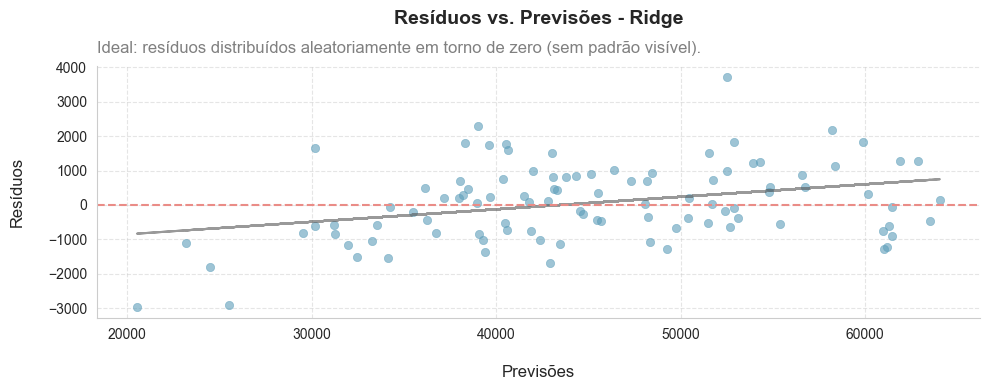

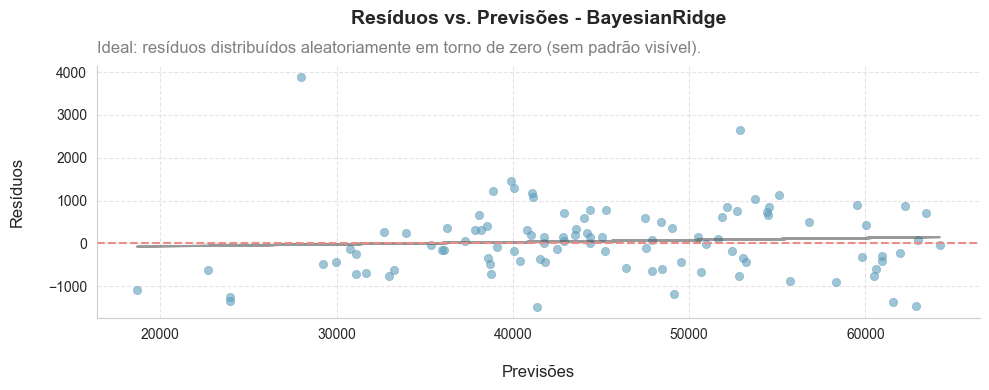

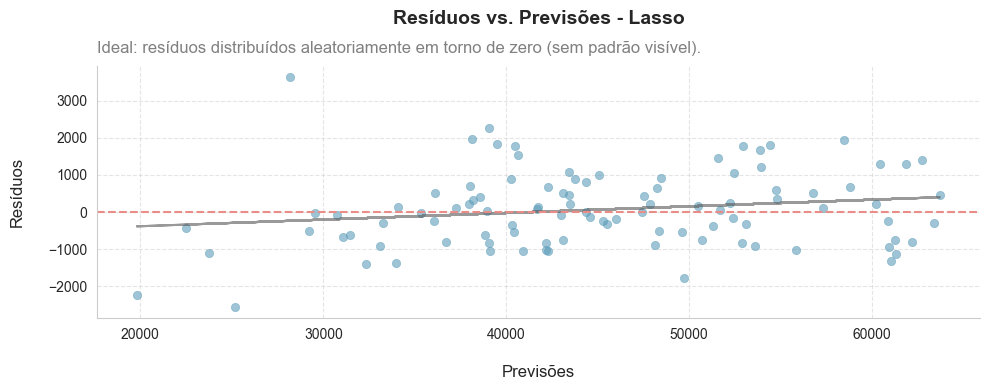

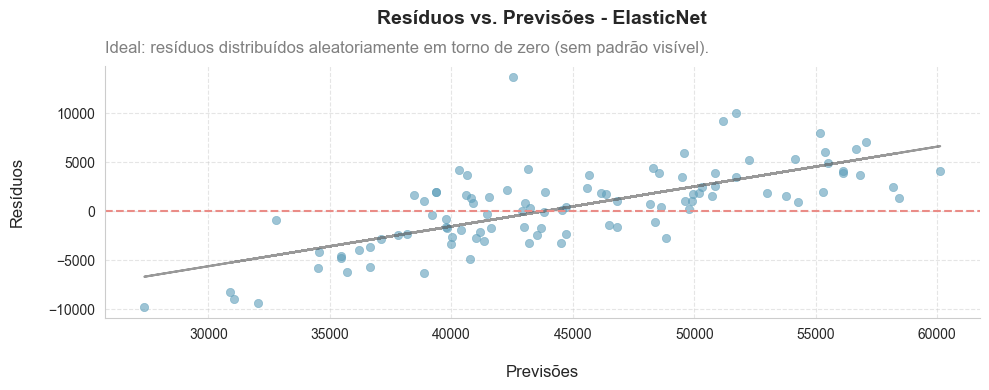

In [90]:
plot_residual_x_forecast(df_ranked_tuned, models, X_train, y_train, X_test, y_test, preprocessor)

## 5. Conclusões